# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-kmeans'
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [9]:
train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BUILD DATASET & DATALOADERS

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [16]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    collected_indices = set()  # Initialize set to store selected indices

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        num_of_candidates = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
    
        # Determine number of clusters
        if num_of_candidates <= n_clusters and n_clusters < nearest_cp - current_train_size:
            n_clusters = n_clusters
        elif num_of_candidates > n_clusters and num_of_candidates < nearest_cp - current_train_size:
            n_clusters = num_of_candidates
        else:
            arrived_at_cp = True
            n_clusters = nearest_cp - current_train_size
            
        kmeans=KMeans(n_clusters=n_clusters, n_init=1)
        kmeans.fit(embeddings)
    
        if current_train_size > checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]  # Indices of samples in the current cluster
                
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances to the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
                closest_sample_index = cluster_indices[np.argmin(cluster_distances)]  # Closest sample index
                collected_indices.add(closest_sample_index)

            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Samples above threshold:", num_of_candidates)
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

# MAIN LOOP

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.8167, F1 Micro: 0.259, F1 Macro: 0.187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8417, F1 Micro: 0.4813, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3739, Accuracy: 0.8522, F1 Micro: 0.5456, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8609, F1 Micro: 0.6048, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2618, Accuracy: 0.867, F1 Micro: 0.678, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2249, Accuracy: 0.8678, F1 Micro: 0.68, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.8722, F1 Micro: 0.6715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5295, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4272, Accuracy: 0.8261, F1 Micro: 0.3299, F1 Macro: 0.2116
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3605, Accuracy: 0.8687, F1 Micro: 0.6656, F1 Macro: 0.6575
Epoch 4/10, Train Loss: 0.2887, Accuracy: 0.8731, F1 Micro: 0.6521, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2456, Accuracy: 0.8845, F1 Micro: 0.7135, F1 Macro: 0.7031
Epoch 6/10, Train Loss: 0.199, Accuracy: 0.8848, F1 Micro: 0.7029, F1 Macro: 0.6925
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1478, Accuracy: 0.8864, F1 Micro: 0.7336, F1 Macro: 0.7255
Epoch 8/10, Train Loss: 0.1123, Accuracy: 0.8892, F1 Micro: 0.7232, F1 Macro: 0.7124
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0974, Accuracy: 0.8877, F1 Micro: 0.7453, F1 Macro: 0.7445
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5121, Accuracy: 0.8064, F1 Micro: 0.1701, F1 Macro: 0.128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3846, Accuracy: 0.8678, F1 Micro: 0.664, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3143, Accuracy: 0.8809, F1 Micro: 0.7231, F1 Macro: 0.7139
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2408, Accuracy: 0.8898, F1 Micro: 0.752, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2067, Accuracy: 0.8964, F1 Micro: 0.764, F1 Macro: 0.757
Epoch 6/10, Train Loss: 0.1629, Accuracy: 0.8973, F1 Micro: 0.7587, F1 Macro: 0.7511
Epoch 7/10, Train Loss: 0.1237, Accuracy: 0.895, F1 Micro: 0.7485, F1 Macro: 0.7357
Epoch 8/10, Train Loss: 0.0914, Accuracy: 0.8963, F1 Micro: 0.7635, F1 Macro: 0.7573
Epoch 9/10, Train Loss: 0.0662, Accuracy: 0.8931, F1 Micro: 0.7264, F1 Macro: 0.7106
Epoch 10/10, Train Loss: 0.0616, Accuracy: 0.8944, F1 Micro: 0.7529, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4935, Accuracy: 0.837, F1 Micro: 0.4279, F1 Macro: 0.3439
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3547, Accuracy: 0.8775, F1 Micro: 0.7012, F1 Macro: 0.698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.272, Accuracy: 0.8859, F1 Micro: 0.7529, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2272, Accuracy: 0.8964, F1 Micro: 0.7623, F1 Macro: 0.7603
Epoch 5/10, Train Loss: 0.1689, Accuracy: 0.8942, F1 Micro: 0.749, F1 Macro: 0.7341
Epoch 6/10, Train Loss: 0.1317, Accuracy: 0.8989, F1 Micro: 0.7526, F1 Macro: 0.7428
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.8978, F1 Micro: 0.7541, F1 Macro: 0.7435
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9013, F1 Micro: 0.7613, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.8986, F1 Micro: 0.778, F1 Macro: 0.7784
Epoch 10/10, Train Loss: 0.0491, Accuracy: 0.8989, F1 Micro: 0.7631, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4828, Accuracy: 0.8417, F1 Micro: 0.4515, F1 Macro: 0.3832
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3311, Accuracy: 0.8795, F1 Micro: 0.687, F1 Macro: 0.6743
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2608, Accuracy: 0.8973, F1 Micro: 0.7569, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2129, Accuracy: 0.8986, F1 Micro: 0.7585, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1686, Accuracy: 0.8919, F1 Micro: 0.7679, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.1316, Accuracy: 0.8991, F1 Micro: 0.7525, F1 Macro: 0.7421
Epoch 7/10, Train Loss: 0.1026, Accuracy: 0.8977, F1 Micro: 0.742, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.8991, F1 Micro: 0.7754, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.8997, F1 Micro: 0.7733, F1 Macro: 0.7728
Epoch 10/10, Train Loss: 0.048, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.479, Accuracy: 0.8595, F1 Micro: 0.6153, F1 Macro: 0.6078
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3256, Accuracy: 0.8888, F1 Micro: 0.7245, F1 Macro: 0.7098
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.261, Accuracy: 0.8928, F1 Micro: 0.7643, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.213, Accuracy: 0.8991, F1 Micro: 0.7717, F1 Macro: 0.7715
Epoch 5/10, Train Loss: 0.1691, Accuracy: 0.9008, F1 Micro: 0.7605, F1 Macro: 0.7522
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.898, F1 Micro: 0.7659, F1 Macro: 0.7598
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.8989, F1 Micro: 0.7655, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9031, F1 Micro: 0.7754, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.8984, F1 Micro: 0.7585, F1 Macro: 0.7492
Epoch 10/10, Train Loss: 0.0446, Accuracy: 0.9013, F1 Micro: 0.774, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4609, Accuracy: 0.8642, F1 Micro: 0.6326, F1 Macro: 0.6284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3115, Accuracy: 0.8845, F1 Micro: 0.7159, F1 Macro: 0.7123
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2654, Accuracy: 0.8958, F1 Micro: 0.7636, F1 Macro: 0.7635
Epoch 4/10, Train Loss: 0.2126, Accuracy: 0.8986, F1 Micro: 0.7464, F1 Macro: 0.7392
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9, F1 Micro: 0.7607, F1 Macro: 0.7556
Epoch 6/10, Train Loss: 0.123, Accuracy: 0.8986, F1 Micro: 0.7524, F1 Macro: 0.7459
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9023, F1 Micro: 0.7797, F1 Macro: 0.7738
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9014, F1 Micro: 0.7703, F1 Macro: 0.7651
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9019, F1 Micro: 0.7803, F1 Macro: 0.7803
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.898, F1 Micro: 0.7512, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4458, Accuracy: 0.8667, F1 Micro: 0.6567, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3094, Accuracy: 0.8947, F1 Micro: 0.7627, F1 Macro: 0.7616
Epoch 3/10, Train Loss: 0.2455, Accuracy: 0.8983, F1 Micro: 0.7566, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1932, Accuracy: 0.8992, F1 Micro: 0.7661, F1 Macro: 0.7626
Epoch 5/10, Train Loss: 0.1519, Accuracy: 0.8997, F1 Micro: 0.7655, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.8997, F1 Micro: 0.7806, F1 Macro: 0.7823
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.9041, F1 Micro: 0.779, F1 Macro: 0.7769
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.8995, F1 Micro: 0.7785, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9022, F1 Micro: 0.7828, F1 Macro: 0.7836
Epoch 10/10, Train Loss: 0.0395, Accuracy: 0.9027, F1 Micro: 0.7722, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4571, Accuracy: 0.8677, F1 Micro: 0.6461, F1 Macro: 0.6472
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2895, Accuracy: 0.8944, F1 Micro: 0.7485, F1 Macro: 0.7344
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2399, Accuracy: 0.8997, F1 Micro: 0.7659, F1 Macro: 0.7614
Epoch 4/10, Train Loss: 0.1954, Accuracy: 0.8944, F1 Micro: 0.722, F1 Macro: 0.7137
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1595, Accuracy: 0.9036, F1 Micro: 0.7664, F1 Macro: 0.7575
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9041, F1 Micro: 0.7748, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0817, Accuracy: 0.9, F1 Micro: 0.7822, F1 Macro: 0.7852
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9002, F1 Micro: 0.7727, F1 Macro: 0.7712
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9002, F1 Micro: 0.7818, F1 Macro: 0.7844
Epoch 10/10, Train Loss: 0.0361, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4335, Accuracy: 0.8723, F1 Micro: 0.6611, F1 Macro: 0.6433
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.295, Accuracy: 0.895, F1 Micro: 0.7581, F1 Macro: 0.7593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.9009, F1 Micro: 0.7757, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1906, Accuracy: 0.9022, F1 Micro: 0.7759, F1 Macro: 0.774
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9028, F1 Micro: 0.7743, F1 Macro: 0.7691
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.8992, F1 Micro: 0.772, F1 Macro: 0.7687
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.9019, F1 Micro: 0.773, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9017, F1 Micro: 0.774, F1 Macro: 0.7715
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0449, Accuracy: 0.9009, F1 Micro: 0.7841, F1 Macro: 0.7823
Epoch 10/10, Train Loss: 0.0372, Accuracy: 0.903, F1 Micro: 0.7785, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4292, Accuracy: 0.8778, F1 Micro: 0.7158, F1 Macro: 0.7108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2867, Accuracy: 0.8956, F1 Micro: 0.728, F1 Macro: 0.7182
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2364, Accuracy: 0.9027, F1 Micro: 0.7735, F1 Macro: 0.7712
Epoch 4/10, Train Loss: 0.2004, Accuracy: 0.8997, F1 Micro: 0.762, F1 Macro: 0.7516
Epoch 5/10, Train Loss: 0.1467, Accuracy: 0.8997, F1 Micro: 0.7704, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.8992, F1 Micro: 0.7741, F1 Macro: 0.7705
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.8994, F1 Micro: 0.7724, F1 Macro: 0.7724
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9, F1 Micro: 0.7668, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.902, F1 Micro: 0.7805, F1 Macro: 0.7795
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.8984, F1 Micro: 0.7601, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4257, Accuracy: 0.87, F1 Micro: 0.6742, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2785, Accuracy: 0.8966, F1 Micro: 0.7554, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2422, Accuracy: 0.9006, F1 Micro: 0.7669, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.8995, F1 Micro: 0.7686, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9039, F1 Micro: 0.7835, F1 Macro: 0.7824
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.9002, F1 Micro: 0.7638, F1 Macro: 0.7597
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.8992, F1 Micro: 0.7702, F1 Macro: 0.7675
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9033, F1 Micro: 0.7672, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9052, F1 Micro: 0.7731, F1 Macro: 0.7706
Epoch 10/10, Train Loss: 0.0423, Accuracy: 0.9038, F1 Micro: 0.7737, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4111, Accuracy: 0.8777, F1 Micro: 0.679, F1 Macro: 0.6587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2898, Accuracy: 0.8983, F1 Micro: 0.7595, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2325, Accuracy: 0.9036, F1 Micro: 0.7747, F1 Macro: 0.7732
Epoch 4/10, Train Loss: 0.1916, Accuracy: 0.9028, F1 Micro: 0.7469, F1 Macro: 0.7297
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1495, Accuracy: 0.8998, F1 Micro: 0.7763, F1 Macro: 0.7771
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.907, F1 Micro: 0.7795, F1 Macro: 0.7784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9047, F1 Micro: 0.7798, F1 Macro: 0.7793
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9011, F1 Micro: 0.7689, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9045, F1 Micro: 0.7803, F1 Macro: 0.7815
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4138, Accuracy: 0.8753, F1 Micro: 0.694, F1 Macro: 0.6963
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2691, Accuracy: 0.8978, F1 Micro: 0.7437, F1 Macro: 0.7373
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2256, Accuracy: 0.9011, F1 Micro: 0.7605, F1 Macro: 0.7501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1777, Accuracy: 0.9022, F1 Micro: 0.7614, F1 Macro: 0.7366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.8984, F1 Micro: 0.7745, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.8963, F1 Micro: 0.7751, F1 Macro: 0.7759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9033, F1 Micro: 0.7782, F1 Macro: 0.7758
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9006, F1 Micro: 0.7753, F1 Macro: 0.773
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9006, F1 Micro: 0.7596, F1 Macro: 0.7529
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4171, Accuracy: 0.885, F1 Micro: 0.7356, F1 Macro: 0.7328
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.269, Accuracy: 0.898, F1 Micro: 0.755, F1 Macro: 0.7456
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.902, F1 Micro: 0.76, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1791, Accuracy: 0.905, F1 Micro: 0.7631, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9011, F1 Micro: 0.7795, F1 Macro: 0.7807
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.9061, F1 Micro: 0.7724, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.9017, F1 Micro: 0.775, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9008, F1 Micro: 0.7759, F1 Macro: 0.7746
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9014, F1 Micro: 0.7693, F1 Macro: 0.7669
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.9005, F1 Micro: 0.7706, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.885, F1 Micro: 0.7125, F1 Macro: 0.7087
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2705, Accuracy: 0.9013, F1 Micro: 0.7599, F1 Macro: 0.7546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2187, Accuracy: 0.9059, F1 Micro: 0.7699, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1826, Accuracy: 0.9039, F1 Micro: 0.7793, F1 Macro: 0.773
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9047, F1 Micro: 0.771, F1 Macro: 0.7638
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.8966, F1 Micro: 0.7724, F1 Macro: 0.7724
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9087, F1 Micro: 0.779, F1 Macro: 0.771
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9016, F1 Micro: 0.7709, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9045, F1 Micro: 0.7846, F1 Macro: 0.7851
Epoch 10/10, Train Loss: 0.0387, Accuracy: 0.9019, F1 Micro: 0.7669, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3989, Accuracy: 0.8864, F1 Micro: 0.7355, F1 Macro: 0.7307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.9019, F1 Micro: 0.7686, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9027, F1 Micro: 0.7717, F1 Macro: 0.7644
Epoch 4/10, Train Loss: 0.1763, Accuracy: 0.9042, F1 Micro: 0.77, F1 Macro: 0.7614
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9047, F1 Micro: 0.7608, F1 Macro: 0.7521
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9028, F1 Micro: 0.763, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9027, F1 Micro: 0.7793, F1 Macro: 0.7787
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9009, F1 Micro: 0.7761, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9017, F1 Micro: 0.7806, F1 Macro: 0.7782
Epoch 10/10, Train Loss: 0.0376, Accuracy: 0.9016, F1 Micro: 0.7706, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3955, Accuracy: 0.878, F1 Micro: 0.6867, F1 Macro: 0.6889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.266, Accuracy: 0.8983, F1 Micro: 0.7651, F1 Macro: 0.7613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2189, Accuracy: 0.9042, F1 Micro: 0.7848, F1 Macro: 0.7798
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9041, F1 Micro: 0.7748, F1 Macro: 0.7713
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.9047, F1 Micro: 0.7715, F1 Macro: 0.7658
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9061, F1 Micro: 0.7723, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9041, F1 Micro: 0.7741, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9044, F1 Micro: 0.7699, F1 Macro: 0.766
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9059, F1 Micro: 0.775, F1 Macro: 0.7715
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.9047, F1 Micro: 0.7742, F1 Macro: 0.7673

 Iteration 5441: Accuracy: 0.9042, F1 Micro: 0.7848, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3896, Accuracy: 0.8805, F1 Micro: 0.6958, F1 Macro: 0.6919
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2517, Accuracy: 0.8975, F1 Micro: 0.7775, F1 Macro: 0.7728
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9025, F1 Micro: 0.7606, F1 Macro: 0.7458
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1656, Accuracy: 0.9022, F1 Micro: 0.7846, F1 Macro: 0.7833
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9053, F1 Micro: 0.7706, F1 Macro: 0.7631
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.8966, F1 Micro: 0.7454, F1 Macro: 0.7331
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9011, F1 Micro: 0.7724, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9028, F1 Micro: 0.7764, F1 Macro: 0.7714
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9028, F1 Micro: 0.7713, F1 Macro: 0.7669
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.9038, F1 Micro: 0.7672, F1 Macro: 0.7574

 Iteration 5641: Accuracy: 0.9022, F1 Micro: 0.78

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3868, Accuracy: 0.8841, F1 Micro: 0.702, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2553, Accuracy: 0.8973, F1 Micro: 0.7605, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9036, F1 Micro: 0.7866, F1 Macro: 0.7851
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9062, F1 Micro: 0.7842, F1 Macro: 0.7804
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.902, F1 Micro: 0.7782, F1 Macro: 0.7703
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9033, F1 Micro: 0.7713, F1 Macro: 0.762
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9081, F1 Micro: 0.7848, F1 Macro: 0.7816
Epoch 8/10, Train Loss: 0.0532, Accuracy: 0.9066, F1 Micro: 0.7857, F1 Macro: 0.7843
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9048, F1 Micro: 0.7773, F1 Macro: 0.7726
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.9023, F1 Micro: 0.7746, F1 Macro: 0.7679

 Iteration 5841: Accuracy: 0.9036, F1 Micro: 0.7866, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3758, Accuracy: 0.8848, F1 Micro: 0.7008, F1 Macro: 0.6964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2469, Accuracy: 0.8991, F1 Micro: 0.7582, F1 Macro: 0.7544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9041, F1 Micro: 0.7754, F1 Macro: 0.762
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.907, F1 Micro: 0.7907, F1 Macro: 0.7874
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9, F1 Micro: 0.7858, F1 Macro: 0.7866
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.9022, F1 Micro: 0.7717, F1 Macro: 0.7691
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9073, F1 Micro: 0.7869, F1 Macro: 0.7874
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.051, Accuracy: 0.9081, F1 Micro: 0.7918, F1 Macro: 0.7903
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9064, F1 Micro: 0.7815, F1 Macro: 0.7807
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.9045, F1 Micro: 0.7792, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3666, Accuracy: 0.8863, F1 Micro: 0.728, F1 Macro: 0.7279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2356, Accuracy: 0.9013, F1 Micro: 0.7688, F1 Macro: 0.7584
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9042, F1 Micro: 0.7824, F1 Macro: 0.7793
Epoch 4/10, Train Loss: 0.1508, Accuracy: 0.9041, F1 Micro: 0.7766, F1 Macro: 0.7699
Epoch 5/10, Train Loss: 0.1229, Accuracy: 0.9078, F1 Micro: 0.7815, F1 Macro: 0.7749
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9064, F1 Micro: 0.7789, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9041, F1 Micro: 0.7878, F1 Macro: 0.7878
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9081, F1 Micro: 0.7816, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9042, F1 Micro: 0.7818, F1 Macro: 0.7785
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9023, F1 Micro: 0.7703, F1 Macro: 0.766

 Iteration 6218: Accu

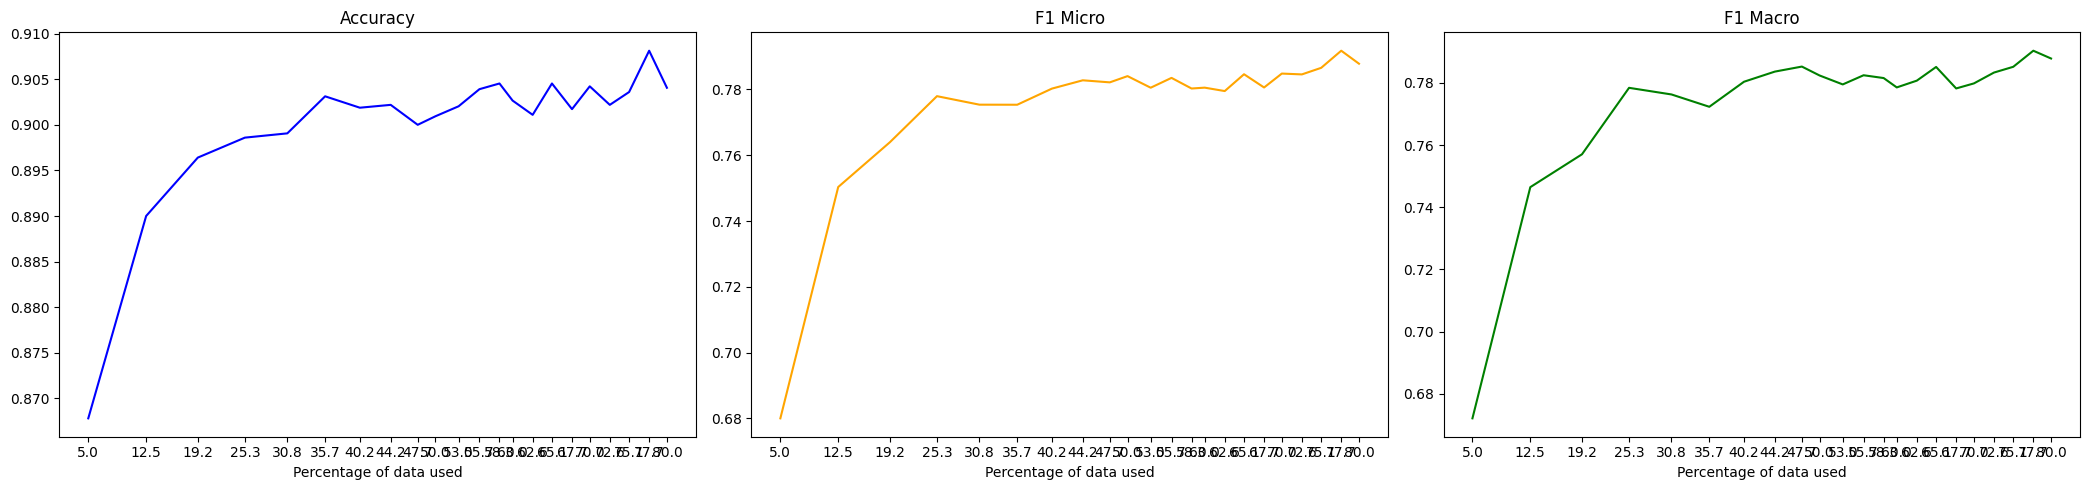

In [19]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5968, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4973, Accuracy: 0.7958, F1 Micro: 0.0815, F1 Macro: 0.0678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4357, Accuracy: 0.8263, F1 Micro: 0.3178, F1 Macro: 0.2216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4166, Accuracy: 0.8441, F1 Micro: 0.4791, F1 Macro: 0.4013
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3434, Accuracy: 0.848, F1 Micro: 0.5003, F1 Macro: 0.4164
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3181, Accuracy: 0.8561, F1 Micro: 0.569, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.28, Accuracy: 0.8608, F1 Micro: 0.6101, F1 Macro: 0.56
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2362, Accuracy: 0.8725, F1 Micro: 0.6686, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1874, Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5437, Accuracy: 0.7889, F1 Micro: 0.0203, F1 Macro: 0.0182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4244, Accuracy: 0.8431, F1 Micro: 0.4898, F1 Macro: 0.4131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.35, Accuracy: 0.8767, F1 Micro: 0.6941, F1 Macro: 0.6848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2734, Accuracy: 0.8827, F1 Micro: 0.7007, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2312, Accuracy: 0.8875, F1 Micro: 0.7172, F1 Macro: 0.7085
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.182, Accuracy: 0.8908, F1 Micro: 0.7412, F1 Macro: 0.7329
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1441, Accuracy: 0.8925, F1 Micro: 0.7495, F1 Macro: 0.7412
Epoch 8/10, Train Loss: 0.1209, Accuracy: 0.8914, F1 Micro: 0.7474, F1 Macro: 0.7434
Epoch 9/10, Train Loss: 0.0945, Accuracy: 0.8902, F1 Micro: 0.7227, F1 Macro: 0.7035
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5222, Accuracy: 0.8091, F1 Micro: 0.1897, F1 Macro: 0.1397
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.389, Accuracy: 0.8727, F1 Micro: 0.6427, F1 Macro: 0.6276
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2884, Accuracy: 0.8852, F1 Micro: 0.7073, F1 Macro: 0.6939
Epoch 4/10, Train Loss: 0.2335, Accuracy: 0.888, F1 Micro: 0.7009, F1 Macro: 0.6757
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1925, Accuracy: 0.8931, F1 Micro: 0.7303, F1 Macro: 0.717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1447, Accuracy: 0.8955, F1 Micro: 0.76, F1 Macro: 0.754
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.8934, F1 Micro: 0.7453, F1 Macro: 0.7461
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.8939, F1 Micro: 0.7427, F1 Macro: 0.7337
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.8955, F1 Micro: 0.7534, F1 Macro: 0.7462
Epoch 10/10, Train Loss: 0.0572, Accuracy: 0.8955, F1 Micro: 0.7586, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.493, Accuracy: 0.8481, F1 Micro: 0.5406, F1 Macro: 0.4612
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3475, Accuracy: 0.8773, F1 Micro: 0.7159, F1 Macro: 0.7085
Epoch 3/10, Train Loss: 0.2758, Accuracy: 0.8886, F1 Micro: 0.7117, F1 Macro: 0.6948
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2231, Accuracy: 0.8922, F1 Micro: 0.7599, F1 Macro: 0.7586
Epoch 5/10, Train Loss: 0.1735, Accuracy: 0.8959, F1 Micro: 0.7562, F1 Macro: 0.7563
Epoch 6/10, Train Loss: 0.1391, Accuracy: 0.8934, F1 Micro: 0.7564, F1 Macro: 0.752
Epoch 7/10, Train Loss: 0.1028, Accuracy: 0.8955, F1 Micro: 0.7593, F1 Macro: 0.7564
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.8952, F1 Micro: 0.7669, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.8973, F1 Micro: 0.7715, F1 Macro: 0.7721
Epoch 10/10, Train Loss: 0.0502, Accuracy: 0.8914, F1 Micro: 0.7646, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4843, Accuracy: 0.8516, F1 Micro: 0.5325, F1 Macro: 0.4805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3235, Accuracy: 0.8834, F1 Micro: 0.7456, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2557, Accuracy: 0.8964, F1 Micro: 0.7476, F1 Macro: 0.7403
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2083, Accuracy: 0.8953, F1 Micro: 0.7691, F1 Macro: 0.7678
Epoch 5/10, Train Loss: 0.1612, Accuracy: 0.8998, F1 Micro: 0.7665, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1276, Accuracy: 0.8986, F1 Micro: 0.7693, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9003, F1 Micro: 0.7598, F1 Macro: 0.7503
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.8986, F1 Micro: 0.766, F1 Macro: 0.762
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9003, F1 Micro: 0.7688, F1 Macro: 0.7622
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0476, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4699, Accuracy: 0.8705, F1 Micro: 0.6595, F1 Macro: 0.6587
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2961, Accuracy: 0.8898, F1 Micro: 0.7283, F1 Macro: 0.7278
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2516, Accuracy: 0.8963, F1 Micro: 0.7342, F1 Macro: 0.7346
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1924, Accuracy: 0.9036, F1 Micro: 0.7609, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9041, F1 Micro: 0.7702, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.9023, F1 Micro: 0.7777, F1 Macro: 0.7788
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9019, F1 Micro: 0.7747, F1 Macro: 0.7747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9042, F1 Micro: 0.7815, F1 Macro: 0.7788
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9019, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4498, Accuracy: 0.8666, F1 Micro: 0.6177, F1 Macro: 0.6079
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2917, Accuracy: 0.895, F1 Micro: 0.7411, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2285, Accuracy: 0.9013, F1 Micro: 0.7645, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1993, Accuracy: 0.8991, F1 Micro: 0.7754, F1 Macro: 0.7736
Epoch 5/10, Train Loss: 0.1521, Accuracy: 0.9013, F1 Micro: 0.7644, F1 Macro: 0.757
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.9048, F1 Micro: 0.7727, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9011, F1 Micro: 0.7789, F1 Macro: 0.7781
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.8988, F1 Micro: 0.7689, F1 Macro: 0.7589
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9066, F1 Micro: 0.7747, F1 Macro: 0.7714
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.9, F1 Micro: 0.7737, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4549, Accuracy: 0.8702, F1 Micro: 0.6477, F1 Macro: 0.6322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2912, Accuracy: 0.8969, F1 Micro: 0.7517, F1 Macro: 0.7358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2357, Accuracy: 0.8981, F1 Micro: 0.7658, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.9041, F1 Micro: 0.7731, F1 Macro: 0.765
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9017, F1 Micro: 0.7609, F1 Macro: 0.7533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9036, F1 Micro: 0.7742, F1 Macro: 0.7696
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9039, F1 Micro: 0.7861, F1 Macro: 0.7867
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9042, F1 Micro: 0.7829, F1 Macro: 0.7845
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9036, F1 Micro: 0.7817, F1 Macro: 0.7815
Epoch 10/10, Train Loss: 0.0367, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4399, Accuracy: 0.8756, F1 Micro: 0.6992, F1 Macro: 0.698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2819, Accuracy: 0.895, F1 Micro: 0.763, F1 Macro: 0.7638
Epoch 3/10, Train Loss: 0.23, Accuracy: 0.9013, F1 Micro: 0.7571, F1 Macro: 0.7567
Epoch 4/10, Train Loss: 0.19, Accuracy: 0.9022, F1 Micro: 0.7592, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1458, Accuracy: 0.9073, F1 Micro: 0.7843, F1 Macro: 0.7816
Epoch 6/10, Train Loss: 0.1178, Accuracy: 0.892, F1 Micro: 0.769, F1 Macro: 0.7677
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.903, F1 Micro: 0.7805, F1 Macro: 0.7784
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9058, F1 Micro: 0.7786, F1 Macro: 0.7743
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9022, F1 Micro: 0.7742, F1 Macro: 0.7706
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0.9002, F1 Micro: 0.7728, F1 Macro: 0.7712

 Iteration 3711: Accuracy: 0.9073, F1 Micro: 0.7843, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4272, Accuracy: 0.8795, F1 Micro: 0.7038, F1 Macro: 0.7042
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2798, Accuracy: 0.9003, F1 Micro: 0.7576, F1 Macro: 0.7534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2224, Accuracy: 0.9023, F1 Micro: 0.7825, F1 Macro: 0.7802
Epoch 4/10, Train Loss: 0.1736, Accuracy: 0.9023, F1 Micro: 0.7648, F1 Macro: 0.7538
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9008, F1 Micro: 0.7754, F1 Macro: 0.7699
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9006, F1 Micro: 0.7853, F1 Macro: 0.7822
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9044, F1 Micro: 0.7703, F1 Macro: 0.7604
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.8975, F1 Micro: 0.7735, F1 Macro: 0.7693
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9009, F1 Micro: 0.7729, F1 Macro: 0.7699
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.9056, F1 Micro: 0.776, F1 Macro: 0.7713

 Iteration 3886: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4234, Accuracy: 0.8797, F1 Micro: 0.7116, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2678, Accuracy: 0.8983, F1 Micro: 0.7476, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2126, Accuracy: 0.9014, F1 Micro: 0.765, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9053, F1 Micro: 0.7737, F1 Macro: 0.7693
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9017, F1 Micro: 0.7705, F1 Macro: 0.7658
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9058, F1 Micro: 0.7701, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9025, F1 Micro: 0.7781, F1 Macro: 0.7761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.8983, F1 Micro: 0.7794, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9034, F1 Micro: 0.7822, F1 Macro: 0.7786
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4157, Accuracy: 0.8861, F1 Micro: 0.7295, F1 Macro: 0.7217
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.275, Accuracy: 0.8941, F1 Micro: 0.7297, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2274, Accuracy: 0.9044, F1 Micro: 0.763, F1 Macro: 0.7588
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9016, F1 Micro: 0.7612, F1 Macro: 0.7482
Epoch 5/10, Train Loss: 0.1417, Accuracy: 0.8998, F1 Micro: 0.7451, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1055, Accuracy: 0.898, F1 Micro: 0.7662, F1 Macro: 0.7611
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9019, F1 Micro: 0.7762, F1 Macro: 0.7713
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.9045, F1 Micro: 0.7751, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9041, F1 Micro: 0.7726, F1 Macro: 0.7627
Epoch 10/10, Train Loss: 0.0378, Accuracy: 0.8928, F1 Micro: 0.7757, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4155, Accuracy: 0.8852, F1 Micro: 0.7315, F1 Macro: 0.7281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2683, Accuracy: 0.8963, F1 Micro: 0.772, F1 Macro: 0.7712
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2217, Accuracy: 0.9014, F1 Micro: 0.7816, F1 Macro: 0.7801
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9041, F1 Micro: 0.7771, F1 Macro: 0.7735
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9019, F1 Micro: 0.7671, F1 Macro: 0.7603
Epoch 6/10, Train Loss: 0.1059, Accuracy: 0.8898, F1 Micro: 0.7751, F1 Macro: 0.7812
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.8977, F1 Micro: 0.7771, F1 Macro: 0.7754
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9005, F1 Micro: 0.778, F1 Macro: 0.7748
Epoch 9/10, Train Loss: 0.0435, Accuracy: 0.9, F1 Micro: 0.7726, F1 Macro: 0.7705
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.8992, F1 Micro: 0.7684, F1 Macro: 0.7614

 Iteration 4530: Accuracy: 0.9014, F1 Micro: 0.7816, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4115, Accuracy: 0.8687, F1 Micro: 0.6237, F1 Macro: 0.5946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2705, Accuracy: 0.8998, F1 Micro: 0.7651, F1 Macro: 0.7568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2224, Accuracy: 0.9045, F1 Micro: 0.7826, F1 Macro: 0.7815
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9025, F1 Micro: 0.777, F1 Macro: 0.7708
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9045, F1 Micro: 0.7718, F1 Macro: 0.7603
Epoch 6/10, Train Loss: 0.1002, Accuracy: 0.8964, F1 Micro: 0.7744, F1 Macro: 0.7707
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9016, F1 Micro: 0.7665, F1 Macro: 0.7569
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9059, F1 Micro: 0.7762, F1 Macro: 0.7658
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9042, F1 Micro: 0.7783, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9067, F1 Micro: 0.7881, F1 Macro: 0.784

 Iteration 4663: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3996, Accuracy: 0.8894, F1 Micro: 0.7266, F1 Macro: 0.7185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2624, Accuracy: 0.9039, F1 Micro: 0.7785, F1 Macro: 0.776
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2115, Accuracy: 0.9008, F1 Micro: 0.7845, F1 Macro: 0.7835
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9025, F1 Micro: 0.7804, F1 Macro: 0.7767
Epoch 5/10, Train Loss: 0.1371, Accuracy: 0.9052, F1 Micro: 0.7774, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.9062, F1 Micro: 0.7848, F1 Macro: 0.7824
Epoch 7/10, Train Loss: 0.0728, Accuracy: 0.8995, F1 Micro: 0.7774, F1 Macro: 0.7736
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9002, F1 Micro: 0.7732, F1 Macro: 0.7703
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.903, F1 Micro: 0.7769, F1 Macro: 0.774
Epoch 10/10, Train Loss: 0.0357, Accuracy: 0.903, F1 Micro: 0.7805, F1 Macro: 0.7737

 Iteration 4863: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4016, Accuracy: 0.877, F1 Micro: 0.7198, F1 Macro: 0.7241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2669, Accuracy: 0.9003, F1 Micro: 0.7755, F1 Macro: 0.7729
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.8994, F1 Micro: 0.7378, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1806, Accuracy: 0.8955, F1 Micro: 0.7768, F1 Macro: 0.7756
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.8973, F1 Micro: 0.7757, F1 Macro: 0.7747
Epoch 6/10, Train Loss: 0.1006, Accuracy: 0.8988, F1 Micro: 0.775, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9078, F1 Micro: 0.7842, F1 Macro: 0.7766
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9062, F1 Micro: 0.7778, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9034, F1 Micro: 0.7841, F1 Macro: 0.7824
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.8983, F1 Micro: 0.7786, F1 Macro: 0.7789

 Iteration 5063: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3883, Accuracy: 0.8845, F1 Micro: 0.6859, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2539, Accuracy: 0.8994, F1 Micro: 0.7405, F1 Macro: 0.7236
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2116, Accuracy: 0.9038, F1 Micro: 0.7869, F1 Macro: 0.7867
Epoch 4/10, Train Loss: 0.1819, Accuracy: 0.902, F1 Micro: 0.7785, F1 Macro: 0.7744
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9058, F1 Micro: 0.7616, F1 Macro: 0.7497
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9042, F1 Micro: 0.7749, F1 Macro: 0.7688
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9047, F1 Micro: 0.7823, F1 Macro: 0.7785
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9044, F1 Micro: 0.7824, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.905, F1 Micro: 0.7883, F1 Macro: 0.7848
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.9066, F1 Micro: 0.777, F1 Macro: 0.7704

 Iteration 5263: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3978, Accuracy: 0.8866, F1 Micro: 0.7135, F1 Macro: 0.6897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2515, Accuracy: 0.9011, F1 Micro: 0.7644, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2165, Accuracy: 0.9056, F1 Micro: 0.7873, F1 Macro: 0.7827
Epoch 4/10, Train Loss: 0.1708, Accuracy: 0.9053, F1 Micro: 0.785, F1 Macro: 0.7856
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9006, F1 Micro: 0.7716, F1 Macro: 0.7655
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9047, F1 Micro: 0.7837, F1 Macro: 0.7807
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9, F1 Micro: 0.7814, F1 Macro: 0.7815
Epoch 8/10, Train Loss: 0.0533, Accuracy: 0.9041, F1 Micro: 0.7741, F1 Macro: 0.7668
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9022, F1 Micro: 0.7727, F1 Macro: 0.7693
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9047, F1 Micro: 0.7834, F1 Macro: 0.7812

 Iteration 5441: Accuracy: 0.9056, F1 Micro: 0.7873, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3837, Accuracy: 0.8855, F1 Micro: 0.7447, F1 Macro: 0.7427
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9014, F1 Micro: 0.7768, F1 Macro: 0.7733
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9033, F1 Micro: 0.7718, F1 Macro: 0.7597
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9075, F1 Micro: 0.7752, F1 Macro: 0.7695
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9041, F1 Micro: 0.7616, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9058, F1 Micro: 0.7824, F1 Macro: 0.7832
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9013, F1 Micro: 0.7765, F1 Macro: 0.7716
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.9052, F1 Micro: 0.7803, F1 Macro: 0.7784
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9038, F1 Micro: 0.7717, F1 Macro: 0.7643
Epoch 10/10, Train Loss: 0.0287, Accuracy: 0.9014, F1 Micro: 0.7686, F1 Macro: 0.7633

 Iteration 5641: Accuracy: 0.9058, F1 Micro: 0.782

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3668, Accuracy: 0.8913, F1 Micro: 0.7539, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.9041, F1 Micro: 0.7813, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9045, F1 Micro: 0.7869, F1 Macro: 0.7835
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.908, F1 Micro: 0.7808, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1227, Accuracy: 0.9047, F1 Micro: 0.7882, F1 Macro: 0.7865
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.902, F1 Micro: 0.7768, F1 Macro: 0.7733
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9056, F1 Micro: 0.7736, F1 Macro: 0.7719
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9022, F1 Micro: 0.7783, F1 Macro: 0.7721
Epoch 9/10, Train Loss: 0.0421, Accuracy: 0.9066, F1 Micro: 0.78, F1 Macro: 0.7726
Epoch 10/10, Train Loss: 0.0317, Accuracy: 0.9031, F1 Micro: 0.7773, F1 Macro: 0.7736

 Iteration 5841: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.8892, F1 Micro: 0.7338, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2373, Accuracy: 0.9033, F1 Micro: 0.7717, F1 Macro: 0.7614
Epoch 3/10, Train Loss: 0.1954, Accuracy: 0.9033, F1 Micro: 0.7602, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9062, F1 Micro: 0.7792, F1 Macro: 0.7702
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9042, F1 Micro: 0.7754, F1 Macro: 0.7689
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9059, F1 Micro: 0.7683, F1 Macro: 0.7619
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9041, F1 Micro: 0.7804, F1 Macro: 0.7788
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.9038, F1 Micro: 0.7773, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9056, F1 Micro: 0.7773, F1 Macro: 0.7739
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9022, F1 Micro: 0.7804, F1 Macro: 0.7778

 Iteration 6041: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.355, Accuracy: 0.8916, F1 Micro: 0.7363, F1 Macro: 0.7325
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2345, Accuracy: 0.9031, F1 Micro: 0.775, F1 Macro: 0.7721
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1892, Accuracy: 0.9034, F1 Micro: 0.7865, F1 Macro: 0.7847
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9064, F1 Micro: 0.7744, F1 Macro: 0.7612
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.9056, F1 Micro: 0.7773, F1 Macro: 0.7718
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.8975, F1 Micro: 0.7752, F1 Macro: 0.7743
Epoch 7/10, Train Loss: 0.0609, Accuracy: 0.9064, F1 Micro: 0.7843, F1 Macro: 0.7815
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9031, F1 Micro: 0.7792, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.9075, F1 Micro: 0.7839, F1 Macro: 0.7824
Epoch 10/10, Train Loss: 0.0285, Accuracy: 0.905, F1 Micro: 0.78, F1 Macro: 0.7748

 Iteration 6218: Accuracy: 0.9034, F1 Micro: 0.7865, F

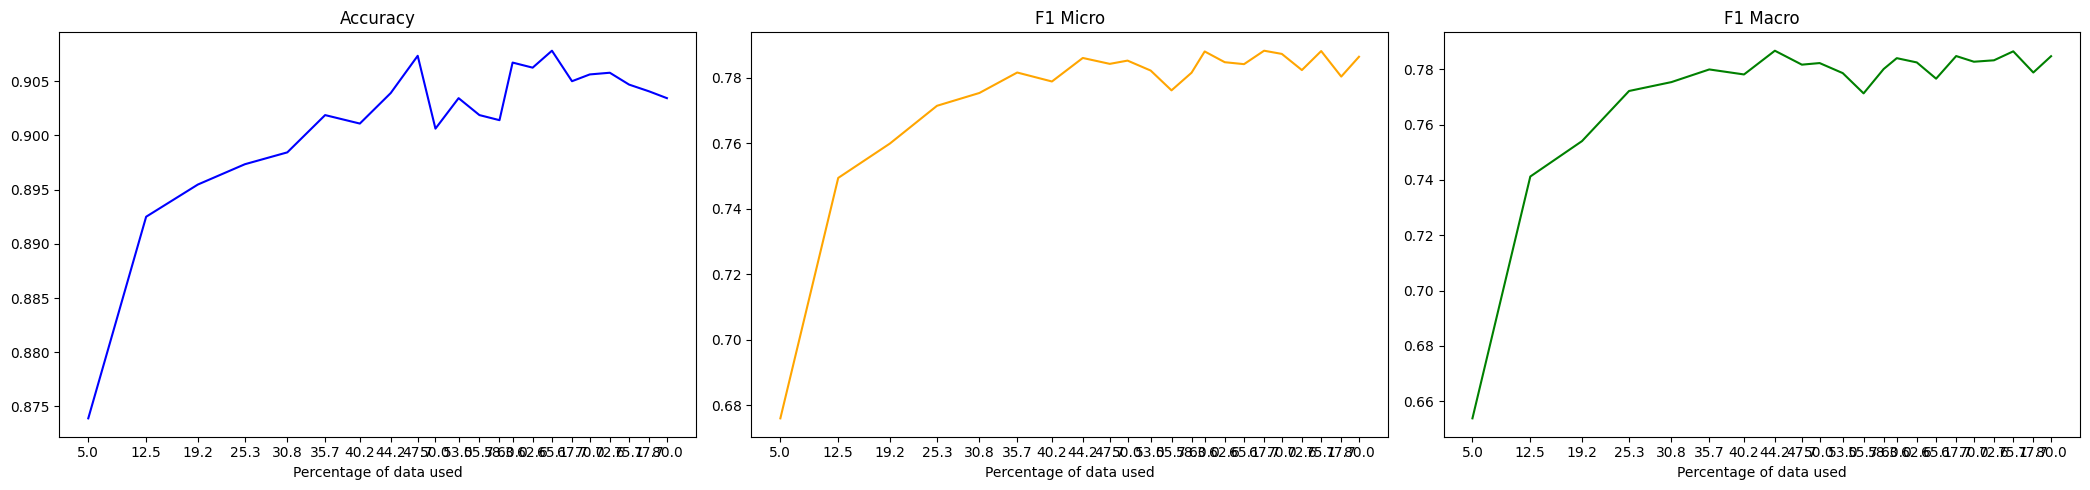

In [20]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.573, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4299, Accuracy: 0.793, F1 Micro: 0.0569, F1 Macro: 0.0488
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.398, Accuracy: 0.8236, F1 Micro: 0.2957, F1 Macro: 0.2101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3572, Accuracy: 0.8389, F1 Micro: 0.4256, F1 Macro: 0.3377
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2998, Accuracy: 0.8417, F1 Micro: 0.4468, F1 Macro: 0.3645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2759, Accuracy: 0.8531, F1 Micro: 0.5406, F1 Macro: 0.4609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2245, Accuracy: 0.8637, F1 Micro: 0.6152, F1 Macro: 0.5822
Epoch 8/10, Train Loss: 0.1944, Accuracy: 0.8647, F1 Micro: 0.5957, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1747, Accuracy: 0.8687, F1 Micro: 0.643

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5257, Accuracy: 0.7877, F1 Micro: 0.0088, F1 Macro: 0.008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4085, Accuracy: 0.8411, F1 Micro: 0.461, F1 Macro: 0.3864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3313, Accuracy: 0.8611, F1 Micro: 0.6026, F1 Macro: 0.597
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2489, Accuracy: 0.8822, F1 Micro: 0.7017, F1 Macro: 0.6902
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2139, Accuracy: 0.888, F1 Micro: 0.7178, F1 Macro: 0.7111
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1707, Accuracy: 0.8881, F1 Micro: 0.7472, F1 Macro: 0.7455
Epoch 7/10, Train Loss: 0.1367, Accuracy: 0.8938, F1 Micro: 0.7424, F1 Macro: 0.7321
Epoch 8/10, Train Loss: 0.1004, Accuracy: 0.8914, F1 Micro: 0.7239, F1 Macro: 0.7115
Epoch 9/10, Train Loss: 0.0834, Accuracy: 0.8913, F1 Micro: 0.7454, F1 Macro: 0.7396
Epoch 10/10, Train Loss: 0.0678, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5145, Accuracy: 0.8156, F1 Micro: 0.2387, F1 Macro: 0.1681
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3679, Accuracy: 0.872, F1 Micro: 0.6653, F1 Macro: 0.6576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2815, Accuracy: 0.8855, F1 Micro: 0.7162, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.22, Accuracy: 0.8934, F1 Micro: 0.7352, F1 Macro: 0.7282
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1915, Accuracy: 0.8941, F1 Micro: 0.75, F1 Macro: 0.7388
Epoch 6/10, Train Loss: 0.1552, Accuracy: 0.895, F1 Micro: 0.7325, F1 Macro: 0.7164
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.8972, F1 Micro: 0.7521, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.078, Accuracy: 0.898, F1 Micro: 0.7625, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.063, Accuracy: 0.8983, F1 Micro: 0.763

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4966, Accuracy: 0.8441, F1 Micro: 0.4954, F1 Macro: 0.4266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3358, Accuracy: 0.878, F1 Micro: 0.6837, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2494, Accuracy: 0.8913, F1 Micro: 0.742, F1 Macro: 0.7365
Epoch 4/10, Train Loss: 0.2098, Accuracy: 0.8938, F1 Micro: 0.7258, F1 Macro: 0.7133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.188, Accuracy: 0.8984, F1 Micro: 0.7616, F1 Macro: 0.7559
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1278, Accuracy: 0.8983, F1 Micro: 0.7671, F1 Macro: 0.7621
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.897, F1 Micro: 0.7571, F1 Macro: 0.7521
Epoch 8/10, Train Loss: 0.0768, Accuracy: 0.8998, F1 Micro: 0.7607, F1 Macro: 0.7509
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.8988, F1 Micro: 0.7612, F1 Macro: 0.7563
Epoch 10/10, Train Loss: 0.0462, Accuracy: 0.8964, F1 Micro: 0.7658, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4773, Accuracy: 0.8492, F1 Micro: 0.5244, F1 Macro: 0.4896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3142, Accuracy: 0.8869, F1 Micro: 0.7185, F1 Macro: 0.7066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.257, Accuracy: 0.8953, F1 Micro: 0.7329, F1 Macro: 0.7242
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2095, Accuracy: 0.8966, F1 Micro: 0.761, F1 Macro: 0.7574
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1667, Accuracy: 0.8953, F1 Micro: 0.7667, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.8988, F1 Micro: 0.76, F1 Macro: 0.7532
Epoch 7/10, Train Loss: 0.0911, Accuracy: 0.898, F1 Micro: 0.7533, F1 Macro: 0.7484
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.8988, F1 Micro: 0.7642, F1 Macro: 0.7601
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9, F1 Micro: 0.7635, F1 Macro: 0.7595
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0.9002, F1 Micro: 0.7639, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4617, Accuracy: 0.8703, F1 Micro: 0.6753, F1 Macro: 0.6729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3108, Accuracy: 0.8895, F1 Micro: 0.7294, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2391, Accuracy: 0.8966, F1 Micro: 0.757, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1956, Accuracy: 0.897, F1 Micro: 0.7703, F1 Macro: 0.7668
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.9009, F1 Micro: 0.7655, F1 Macro: 0.7621
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9013, F1 Micro: 0.7692, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.9013, F1 Micro: 0.7717, F1 Macro: 0.7679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9023, F1 Micro: 0.7761, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9023, F1 Micro: 0.7781, F1 Macro: 0.7734
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4478, Accuracy: 0.8611, F1 Micro: 0.6012, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2938, Accuracy: 0.8909, F1 Micro: 0.7256, F1 Macro: 0.7118
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.8966, F1 Micro: 0.7375, F1 Macro: 0.732
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.9008, F1 Micro: 0.759, F1 Macro: 0.7411
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1483, Accuracy: 0.9002, F1 Micro: 0.7717, F1 Macro: 0.77
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9023, F1 Micro: 0.7689, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9038, F1 Micro: 0.7822, F1 Macro: 0.7796
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9047, F1 Micro: 0.7785, F1 Macro: 0.7746
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9002, F1 Micro: 0.7771, F1 Macro: 0.7742
Epoch 10/10, Train Loss: 0.0415, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4396, Accuracy: 0.8589, F1 Micro: 0.5631, F1 Macro: 0.5378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2893, Accuracy: 0.8919, F1 Micro: 0.7514, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2289, Accuracy: 0.8986, F1 Micro: 0.7617, F1 Macro: 0.7581
Epoch 4/10, Train Loss: 0.1876, Accuracy: 0.9009, F1 Micro: 0.7615, F1 Macro: 0.7506
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9005, F1 Micro: 0.7617, F1 Macro: 0.7525
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.8986, F1 Micro: 0.7507, F1 Macro: 0.7463
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.8988, F1 Micro: 0.7712, F1 Macro: 0.7657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9028, F1 Micro: 0.7767, F1 Macro: 0.7695
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9031, F1 Micro: 0.7741, F1 Macro: 0.7706
Epoch 10/10, Train Loss: 0.0368, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4363, Accuracy: 0.8763, F1 Micro: 0.6944, F1 Macro: 0.6926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2835, Accuracy: 0.8948, F1 Micro: 0.742, F1 Macro: 0.7319
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2325, Accuracy: 0.9016, F1 Micro: 0.7545, F1 Macro: 0.7425
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9042, F1 Micro: 0.7737, F1 Macro: 0.7701
Epoch 5/10, Train Loss: 0.1512, Accuracy: 0.908, F1 Micro: 0.7725, F1 Macro: 0.7676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9023, F1 Micro: 0.7792, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9056, F1 Micro: 0.7882, F1 Macro: 0.7853
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9022, F1 Micro: 0.7837, F1 Macro: 0.7801
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9016, F1 Micro: 0.7716, F1 Macro: 0.7643
Epoch 10/10, Train Loss: 0.0334, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4173, Accuracy: 0.8692, F1 Micro: 0.6563, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2721, Accuracy: 0.8933, F1 Micro: 0.7469, F1 Macro: 0.7355
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2173, Accuracy: 0.9003, F1 Micro: 0.75, F1 Macro: 0.7461
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1812, Accuracy: 0.9009, F1 Micro: 0.7736, F1 Macro: 0.768
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9005, F1 Micro: 0.7645, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9041, F1 Micro: 0.7801, F1 Macro: 0.7766
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9014, F1 Micro: 0.7708, F1 Macro: 0.767
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.9003, F1 Micro: 0.775, F1 Macro: 0.7727
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9042, F1 Micro: 0.7725, F1 Macro: 0.77
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.9045, F1 Micro: 0.7797, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4178, Accuracy: 0.8834, F1 Micro: 0.7241, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.8898, F1 Micro: 0.7671, F1 Macro: 0.7696
Epoch 3/10, Train Loss: 0.2217, Accuracy: 0.9009, F1 Micro: 0.7634, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9031, F1 Micro: 0.7805, F1 Macro: 0.7751
Epoch 5/10, Train Loss: 0.1422, Accuracy: 0.9013, F1 Micro: 0.7776, F1 Macro: 0.7738
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.903, F1 Micro: 0.7748, F1 Macro: 0.7693
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9048, F1 Micro: 0.7778, F1 Macro: 0.7722
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9031, F1 Micro: 0.7652, F1 Macro: 0.7559
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9034, F1 Micro: 0.7701, F1 Macro: 0.7624
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.9008, F1 Micro: 0.771, F1 Macro: 0.7658

 Iteration 4120: Accuracy: 0.9031, F1 Micro: 0.7805,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4184, Accuracy: 0.8788, F1 Micro: 0.7122, F1 Macro: 0.7104
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2646, Accuracy: 0.9009, F1 Micro: 0.7567, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2188, Accuracy: 0.9056, F1 Micro: 0.78, F1 Macro: 0.7744
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9041, F1 Micro: 0.7748, F1 Macro: 0.7682
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.8972, F1 Micro: 0.7698, F1 Macro: 0.7686
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9036, F1 Micro: 0.7712, F1 Macro: 0.7707
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.9027, F1 Micro: 0.7707, F1 Macro: 0.7664
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.903, F1 Micro: 0.7733, F1 Macro: 0.7648
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9, F1 Micro: 0.7695, F1 Macro: 0.7658
Epoch 10/10, Train Loss: 0.0367, Accuracy: 0.9048, F1 Micro: 0.7653, F1 Macro: 0.7562

 Iteration 4330: Accuracy: 0.9056, F1 Micro: 0.78, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4065, Accuracy: 0.8769, F1 Micro: 0.6853, F1 Macro: 0.6809
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2661, Accuracy: 0.8986, F1 Micro: 0.7512, F1 Macro: 0.7411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2171, Accuracy: 0.9031, F1 Micro: 0.7795, F1 Macro: 0.7759
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9047, F1 Micro: 0.7849, F1 Macro: 0.7839
Epoch 5/10, Train Loss: 0.1437, Accuracy: 0.9036, F1 Micro: 0.7639, F1 Macro: 0.7506
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9016, F1 Micro: 0.7672, F1 Macro: 0.754
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.8998, F1 Micro: 0.7739, F1 Macro: 0.7693
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9016, F1 Micro: 0.7744, F1 Macro: 0.7715
Epoch 9/10, Train Loss: 0.0439, Accuracy: 0.9034, F1 Micro: 0.7771, F1 Macro: 0.7716
Epoch 10/10, Train Loss: 0.0344, Accuracy: 0.902, F1 Micro: 0.7711, F1 Macro: 0.7646

 Iteration 4530: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4038, Accuracy: 0.8806, F1 Micro: 0.7358, F1 Macro: 0.7323
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9, F1 Micro: 0.761, F1 Macro: 0.755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2177, Accuracy: 0.9027, F1 Micro: 0.7807, F1 Macro: 0.7752
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.9023, F1 Micro: 0.7542, F1 Macro: 0.7482
Epoch 5/10, Train Loss: 0.131, Accuracy: 0.9075, F1 Micro: 0.7734, F1 Macro: 0.7608
Epoch 6/10, Train Loss: 0.0963, Accuracy: 0.9045, F1 Micro: 0.7758, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.903, F1 Micro: 0.7764, F1 Macro: 0.7718
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9031, F1 Micro: 0.7762, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9019, F1 Micro: 0.7793, F1 Macro: 0.7771
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.038, Accuracy: 0.9045, F1 Micro: 0.7833, F1 Macro: 0.7785

 Iteration 4663: Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3999, Accuracy: 0.8789, F1 Micro: 0.6596, F1 Macro: 0.6313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.8981, F1 Micro: 0.7638, F1 Macro: 0.7603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.907, F1 Micro: 0.7726, F1 Macro: 0.7679
Epoch 4/10, Train Loss: 0.1703, Accuracy: 0.9022, F1 Micro: 0.7655, F1 Macro: 0.7601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1351, Accuracy: 0.9044, F1 Micro: 0.7763, F1 Macro: 0.77
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.8991, F1 Micro: 0.7664, F1 Macro: 0.7576
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9066, F1 Micro: 0.7806, F1 Macro: 0.7768
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9027, F1 Micro: 0.7787, F1 Macro: 0.7742
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.8998, F1 Micro: 0.7777, F1 Macro: 0.78
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9031, F1 Micro: 0.7685, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3867, Accuracy: 0.8866, F1 Micro: 0.7453, F1 Macro: 0.7414
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.9019, F1 Micro: 0.7721, F1 Macro: 0.7694
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.9031, F1 Micro: 0.782, F1 Macro: 0.7729
Epoch 4/10, Train Loss: 0.1774, Accuracy: 0.9066, F1 Micro: 0.7779, F1 Macro: 0.772
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9058, F1 Micro: 0.7805, F1 Macro: 0.7766
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9023, F1 Micro: 0.7743, F1 Macro: 0.7729
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9038, F1 Micro: 0.7757, F1 Macro: 0.774
Epoch 8/10, Train Loss: 0.0548, Accuracy: 0.9062, F1 Micro: 0.7805, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9038, F1 Micro: 0.7817, F1 Macro: 0.7807
Epoch 10/10, Train Loss: 0.0348, Accuracy: 0.8998, F1 Micro: 0.7742, F1 Macro: 0.7755

 Iteration 5063: Accuracy: 0.9031, F1 Micro: 0.782, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8883, F1 Micro: 0.7446, F1 Macro: 0.7363
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2601, Accuracy: 0.8991, F1 Micro: 0.7656, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.9056, F1 Micro: 0.7753, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1742, Accuracy: 0.9017, F1 Micro: 0.7781, F1 Macro: 0.7759
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9066, F1 Micro: 0.7887, F1 Macro: 0.7889
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9013, F1 Micro: 0.7749, F1 Macro: 0.7713
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9069, F1 Micro: 0.7788, F1 Macro: 0.7724
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.8984, F1 Micro: 0.7783, F1 Macro: 0.7755
Epoch 9/10, Train Loss: 0.0419, Accuracy: 0.9022, F1 Micro: 0.772, F1 Macro: 0.768
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9003, F1 Micro: 0.7812, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.8848, F1 Micro: 0.7022, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2592, Accuracy: 0.9023, F1 Micro: 0.7723, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2054, Accuracy: 0.905, F1 Micro: 0.7807, F1 Macro: 0.779
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9047, F1 Micro: 0.7854, F1 Macro: 0.7802
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.9034, F1 Micro: 0.7735, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0912, Accuracy: 0.903, F1 Micro: 0.7659, F1 Macro: 0.7595
Epoch 7/10, Train Loss: 0.0701, Accuracy: 0.9013, F1 Micro: 0.7735, F1 Macro: 0.7689
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.902, F1 Micro: 0.776, F1 Macro: 0.7709
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9027, F1 Micro: 0.775, F1 Macro: 0.7724
Epoch 10/10, Train Loss: 0.0297, Accuracy: 0.9061, F1 Micro: 0.776, F1 Macro: 0.7685

 Iteration 5441: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3787, Accuracy: 0.8889, F1 Micro: 0.7489, F1 Macro: 0.7475
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2451, Accuracy: 0.9011, F1 Micro: 0.7687, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9058, F1 Micro: 0.7808, F1 Macro: 0.7739
Epoch 4/10, Train Loss: 0.1639, Accuracy: 0.9072, F1 Micro: 0.7803, F1 Macro: 0.7759
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9025, F1 Micro: 0.7807, F1 Macro: 0.7775
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9056, F1 Micro: 0.7791, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0693, Accuracy: 0.8995, F1 Micro: 0.7831, F1 Macro: 0.7825
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9059, F1 Micro: 0.7755, F1 Macro: 0.7729
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9014, F1 Micro: 0.7773, F1 Macro: 0.7763
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.9056, F1 Micro: 0.7761, F1 Macro: 0.7709

 Iteration 5641: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3745, Accuracy: 0.8916, F1 Micro: 0.7304, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2409, Accuracy: 0.9005, F1 Micro: 0.7801, F1 Macro: 0.7783
Epoch 3/10, Train Loss: 0.1993, Accuracy: 0.907, F1 Micro: 0.7777, F1 Macro: 0.7733
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9011, F1 Micro: 0.7714, F1 Macro: 0.7641
Epoch 5/10, Train Loss: 0.129, Accuracy: 0.9048, F1 Micro: 0.7653, F1 Macro: 0.7545
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9031, F1 Micro: 0.7705, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9067, F1 Micro: 0.7828, F1 Macro: 0.7792
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.905, F1 Micro: 0.7771, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0411, Accuracy: 0.9062, F1 Micro: 0.7863, F1 Macro: 0.7843
Epoch 10/10, Train Loss: 0.0316, Accuracy: 0.9061, F1 Micro: 0.7807, F1 Macro: 0.7796

 Iteration 5841: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3668, Accuracy: 0.8884, F1 Micro: 0.7452, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2432, Accuracy: 0.8994, F1 Micro: 0.7606, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1953, Accuracy: 0.9059, F1 Micro: 0.7835, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9033, F1 Micro: 0.7847, F1 Macro: 0.7799
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9002, F1 Micro: 0.7818, F1 Macro: 0.7814
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9066, F1 Micro: 0.7805, F1 Macro: 0.7747
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9017, F1 Micro: 0.7676, F1 Macro: 0.7643
Epoch 8/10, Train Loss: 0.0471, Accuracy: 0.9064, F1 Micro: 0.7837, F1 Macro: 0.7811
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.9053, F1 Micro: 0.7851, F1 Macro: 0.7803
Epoch 10/10, Train Loss: 0.031, Accuracy: 0.9058, F1 Micro: 0.7758, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3549, Accuracy: 0.8909, F1 Micro: 0.7307, F1 Macro: 0.7156
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.9008, F1 Micro: 0.7715, F1 Macro: 0.7682
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1892, Accuracy: 0.9033, F1 Micro: 0.7753, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9047, F1 Micro: 0.777, F1 Macro: 0.7684
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9044, F1 Micro: 0.7569, F1 Macro: 0.7497
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9059, F1 Micro: 0.778, F1 Macro: 0.7764
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.8983, F1 Micro: 0.7776, F1 Macro: 0.7784
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0484, Accuracy: 0.9053, F1 Micro: 0.7803, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9058, F1 Micro: 0.7794, F1 Macro: 0.7783
Higher F1 achieved, saving model
Epoch 

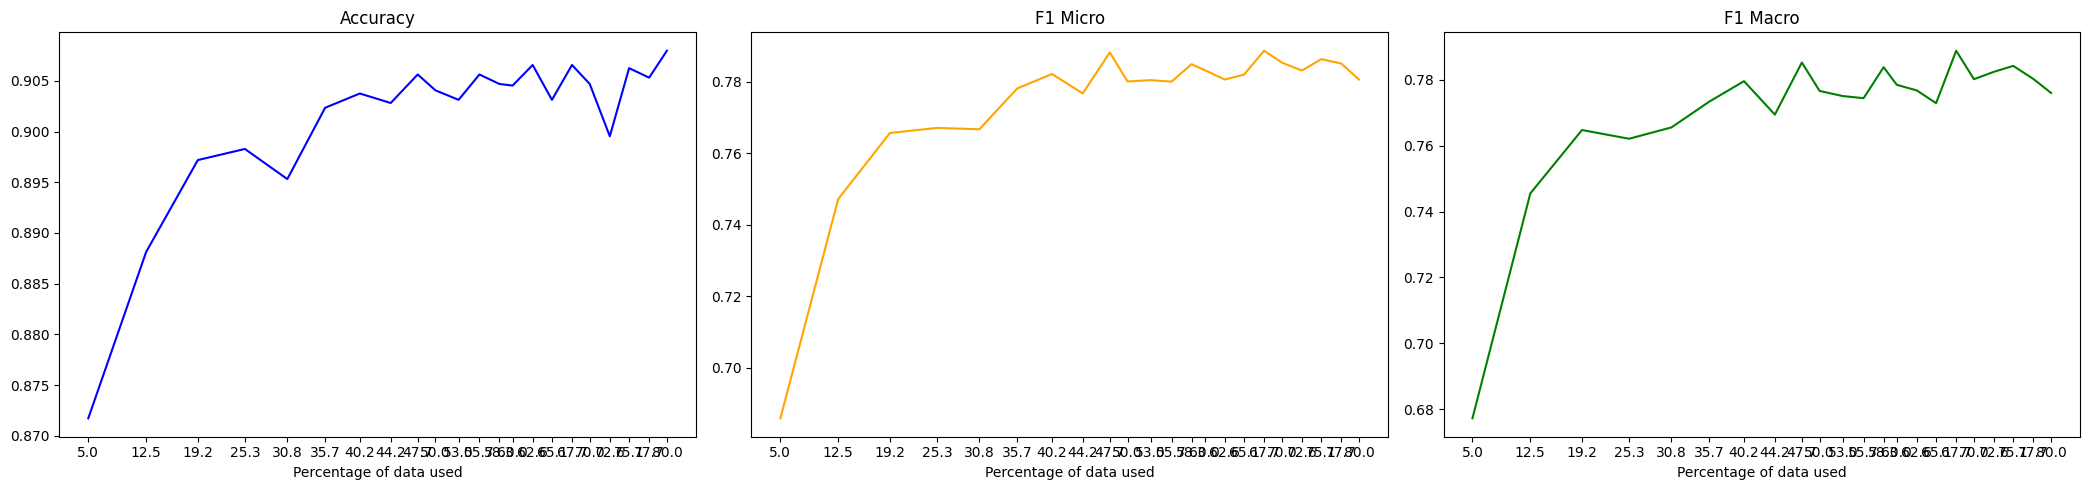

In [21]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6187, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4493, Accuracy: 0.7884, F1 Micro: 0.016, F1 Macro: 0.0144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4203, Accuracy: 0.8111, F1 Micro: 0.2051, F1 Macro: 0.1483
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3885, Accuracy: 0.8291, F1 Micro: 0.3587, F1 Macro: 0.2765
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3558, Accuracy: 0.8389, F1 Micro: 0.4418, F1 Macro: 0.3567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2968, Accuracy: 0.855, F1 Micro: 0.5455, F1 Macro: 0.48
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2508, Accuracy: 0.8719, F1 Micro: 0.6664, F1 Macro: 0.6505
Epoch 8/10, Train Loss: 0.2154, Accuracy: 0.8605, F1 Micro: 0.5802, F1 Macro: 0.5478
Epoch 9/10, Train Loss: 0.1636, Accuracy: 0.867, F1 Micro: 0.6343, F1 Macro: 0.6221
Higher F1 achie

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5612, Accuracy: 0.7884, F1 Micro: 0.016, F1 Macro: 0.0144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.431, Accuracy: 0.8356, F1 Micro: 0.4258, F1 Macro: 0.3347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3345, Accuracy: 0.8627, F1 Micro: 0.6123, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.275, Accuracy: 0.87, F1 Micro: 0.6817, F1 Macro: 0.6863
Epoch 5/10, Train Loss: 0.2324, Accuracy: 0.8789, F1 Micro: 0.6729, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2001, Accuracy: 0.8891, F1 Micro: 0.7547, F1 Macro: 0.753
Epoch 7/10, Train Loss: 0.1608, Accuracy: 0.8869, F1 Micro: 0.7127, F1 Macro: 0.7007
Epoch 8/10, Train Loss: 0.1321, Accuracy: 0.8881, F1 Micro: 0.7406, F1 Macro: 0.7352
Epoch 9/10, Train Loss: 0.0863, Accuracy: 0.8873, F1 Micro: 0.7346, F1 Macro: 0.731
Epoch 10/10, Train Loss: 0.0753, Accuracy: 0.888, F1 Micro: 0.7405, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5119, Accuracy: 0.8075, F1 Micro: 0.1776, F1 Macro: 0.1325
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3668, Accuracy: 0.8519, F1 Micro: 0.5265, F1 Macro: 0.4674
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2828, Accuracy: 0.8847, F1 Micro: 0.7223, F1 Macro: 0.7106
Epoch 4/10, Train Loss: 0.224, Accuracy: 0.8883, F1 Micro: 0.7191, F1 Macro: 0.7032
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1776, Accuracy: 0.8906, F1 Micro: 0.7482, F1 Macro: 0.7417
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.8897, F1 Micro: 0.7293, F1 Macro: 0.7144
Epoch 7/10, Train Loss: 0.1084, Accuracy: 0.8859, F1 Micro: 0.7411, F1 Macro: 0.7333
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.8928, F1 Micro: 0.7444, F1 Macro: 0.7391
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.8875, F1 Micro: 0.7271, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0499, Accuracy: 0.8906, F1 Micro: 0.7505, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4861, Accuracy: 0.8452, F1 Micro: 0.4926, F1 Macro: 0.4124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3328, Accuracy: 0.8744, F1 Micro: 0.7129, F1 Macro: 0.7146
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2689, Accuracy: 0.8881, F1 Micro: 0.7269, F1 Macro: 0.7255
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2232, Accuracy: 0.892, F1 Micro: 0.7679, F1 Macro: 0.7689
Epoch 5/10, Train Loss: 0.1806, Accuracy: 0.8958, F1 Micro: 0.7568, F1 Macro: 0.7519
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.8964, F1 Micro: 0.7553, F1 Macro: 0.7505
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.8945, F1 Micro: 0.7391, F1 Macro: 0.7327
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.8948, F1 Micro: 0.736, F1 Macro: 0.7262
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.8961, F1 Micro: 0.7614, F1 Macro: 0.7564
Epoch 10/10, Train Loss: 0.0485, Accuracy: 0.8931, F1 Micro: 0.752, F1 Macro: 0.7455

 Iteration 1969: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4777, Accuracy: 0.8491, F1 Micro: 0.5315, F1 Macro: 0.4546
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3164, Accuracy: 0.8834, F1 Micro: 0.7307, F1 Macro: 0.7175
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2441, Accuracy: 0.8977, F1 Micro: 0.7636, F1 Macro: 0.7621
Epoch 4/10, Train Loss: 0.1937, Accuracy: 0.898, F1 Micro: 0.7631, F1 Macro: 0.7608
Epoch 5/10, Train Loss: 0.1589, Accuracy: 0.8969, F1 Micro: 0.7523, F1 Macro: 0.7414
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.8969, F1 Micro: 0.7628, F1 Macro: 0.7578
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.8866, F1 Micro: 0.7438, F1 Macro: 0.7321
Epoch 8/10, Train Loss: 0.0665, Accuracy: 0.8986, F1 Micro: 0.7624, F1 Macro: 0.7559
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.8947, F1 Micro: 0.7544, F1 Macro: 0.7467
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0414, Accuracy: 0.8955, F1 Micro: 0.7649, F1 Macro: 0.7628

 Iteration 2394: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4618, Accuracy: 0.8572, F1 Micro: 0.583, F1 Macro: 0.5162
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3057, Accuracy: 0.8933, F1 Micro: 0.742, F1 Macro: 0.7337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2435, Accuracy: 0.8953, F1 Micro: 0.7641, F1 Macro: 0.7626
Epoch 4/10, Train Loss: 0.1919, Accuracy: 0.8978, F1 Micro: 0.7618, F1 Macro: 0.7545
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.8977, F1 Micro: 0.7478, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1117, Accuracy: 0.8959, F1 Micro: 0.7722, F1 Macro: 0.7727
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.8941, F1 Micro: 0.77, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.8953, F1 Micro: 0.7574, F1 Macro: 0.7525
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.8934, F1 Micro: 0.7609, F1 Macro: 0.7585
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0.8981, F1 Micro: 0.7536, F1 Macro: 0.7487

 Iteration 2777: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4528, Accuracy: 0.867, F1 Micro: 0.6595, F1 Macro: 0.6509
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2956, Accuracy: 0.8938, F1 Micro: 0.7399, F1 Macro: 0.7302
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2414, Accuracy: 0.8991, F1 Micro: 0.7408, F1 Macro: 0.7314
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1904, Accuracy: 0.902, F1 Micro: 0.7571, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.8989, F1 Micro: 0.7658, F1 Macro: 0.7625
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9011, F1 Micro: 0.7589, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.8986, F1 Micro: 0.7698, F1 Macro: 0.7677
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.8972, F1 Micro: 0.7481, F1 Macro: 0.7405
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.8972, F1 Micro: 0.7508, F1 Macro: 0.745
Epoch 10/10, Train Loss: 0.0378, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4407, Accuracy: 0.8655, F1 Micro: 0.639, F1 Macro: 0.6364
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2853, Accuracy: 0.8869, F1 Micro: 0.7507, F1 Macro: 0.7548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2327, Accuracy: 0.903, F1 Micro: 0.7694, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.9034, F1 Micro: 0.7783, F1 Macro: 0.7763
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9, F1 Micro: 0.7623, F1 Macro: 0.7596
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.8981, F1 Micro: 0.7591, F1 Macro: 0.7528
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9017, F1 Micro: 0.7732, F1 Macro: 0.7695
Epoch 8/10, Train Loss: 0.0545, Accuracy: 0.9005, F1 Micro: 0.7662, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.8998, F1 Micro: 0.7637, F1 Macro: 0.7589
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.8966, F1 Micro: 0.7719, F1 Macro: 0.7705

 Iteration 3432: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4255, Accuracy: 0.8652, F1 Micro: 0.6385, F1 Macro: 0.6254
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2685, Accuracy: 0.8922, F1 Micro: 0.7255, F1 Macro: 0.711
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2201, Accuracy: 0.8989, F1 Micro: 0.757, F1 Macro: 0.7515
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.8998, F1 Micro: 0.7622, F1 Macro: 0.7572
Epoch 5/10, Train Loss: 0.1451, Accuracy: 0.9016, F1 Micro: 0.7488, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9019, F1 Micro: 0.7684, F1 Macro: 0.7648
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9009, F1 Micro: 0.7595, F1 Macro: 0.7532
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9002, F1 Micro: 0.7608, F1 Macro: 0.756
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.8991, F1 Micro: 0.7676, F1 Macro: 0.7647
Epoch 10/10, Train Loss: 0.0373, Accuracy: 0.8992, F1 Micro: 0.7682, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4232, Accuracy: 0.8642, F1 Micro: 0.621, F1 Macro: 0.6118
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2718, Accuracy: 0.8948, F1 Micro: 0.745, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2317, Accuracy: 0.9002, F1 Micro: 0.7752, F1 Macro: 0.7738
Epoch 4/10, Train Loss: 0.1848, Accuracy: 0.9022, F1 Micro: 0.7659, F1 Macro: 0.7542
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.8988, F1 Micro: 0.782, F1 Macro: 0.7829
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.9008, F1 Micro: 0.7773, F1 Macro: 0.7753
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9023, F1 Micro: 0.7708, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.8967, F1 Micro: 0.7609, F1 Macro: 0.7578
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9023, F1 Micro: 0.7746, F1 Macro: 0.7704
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.8986, F1 Micro: 0.766, F1 Macro: 0.7615

 Iteration 3886: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4206, Accuracy: 0.8737, F1 Micro: 0.6821, F1 Macro: 0.6794
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2757, Accuracy: 0.8972, F1 Micro: 0.7487, F1 Macro: 0.7473
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2248, Accuracy: 0.9011, F1 Micro: 0.7696, F1 Macro: 0.7642
Epoch 4/10, Train Loss: 0.1909, Accuracy: 0.9031, F1 Micro: 0.7652, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1434, Accuracy: 0.9016, F1 Micro: 0.7726, F1 Macro: 0.7714
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1009, Accuracy: 0.9014, F1 Micro: 0.7819, F1 Macro: 0.7825
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.8995, F1 Micro: 0.7691, F1 Macro: 0.7664
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.8981, F1 Micro: 0.7645, F1 Macro: 0.7581
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.8953, F1 Micro: 0.7586, F1 Macro: 0.7533
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.8986, F1 Micro: 0.7611, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4153, Accuracy: 0.8805, F1 Micro: 0.7043, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.8958, F1 Micro: 0.7408, F1 Macro: 0.7311
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.222, Accuracy: 0.9019, F1 Micro: 0.7674, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.9087, F1 Micro: 0.7892, F1 Macro: 0.7835
Epoch 5/10, Train Loss: 0.1342, Accuracy: 0.9014, F1 Micro: 0.7666, F1 Macro: 0.7599
Epoch 6/10, Train Loss: 0.1042, Accuracy: 0.9013, F1 Micro: 0.7786, F1 Macro: 0.7782
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9033, F1 Micro: 0.7587, F1 Macro: 0.7532
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9013, F1 Micro: 0.7744, F1 Macro: 0.7712
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.8986, F1 Micro: 0.7673, F1 Macro: 0.7624
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9041, F1 Micro: 0.7695, F1 Macro: 0.766

 Iteration 4330: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4078, Accuracy: 0.8866, F1 Micro: 0.7254, F1 Macro: 0.7204
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.897, F1 Micro: 0.7719, F1 Macro: 0.771
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9017, F1 Micro: 0.7513, F1 Macro: 0.7415
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9003, F1 Micro: 0.76, F1 Macro: 0.7532
Epoch 5/10, Train Loss: 0.1411, Accuracy: 0.9042, F1 Micro: 0.7584, F1 Macro: 0.7407
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9055, F1 Micro: 0.7815, F1 Macro: 0.7791
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9025, F1 Micro: 0.7739, F1 Macro: 0.7722
Epoch 8/10, Train Loss: 0.0534, Accuracy: 0.9022, F1 Micro: 0.7715, F1 Macro: 0.7655
Epoch 9/10, Train Loss: 0.044, Accuracy: 0.9009, F1 Micro: 0.7686, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0382, Accuracy: 0.8945, F1 Micro: 0.7711, F1 Macro: 0.7671

 Iteration 4530: Accuracy: 0.9055, F1 Micro: 0.7815, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4119, Accuracy: 0.8803, F1 Micro: 0.7003, F1 Macro: 0.6997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2678, Accuracy: 0.8959, F1 Micro: 0.744, F1 Macro: 0.7237
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.9013, F1 Micro: 0.761, F1 Macro: 0.751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.175, Accuracy: 0.9005, F1 Micro: 0.77, F1 Macro: 0.7629
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.8992, F1 Micro: 0.764, F1 Macro: 0.7633
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.903, F1 Micro: 0.7657, F1 Macro: 0.7592
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9005, F1 Micro: 0.7581, F1 Macro: 0.75
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.8989, F1 Micro: 0.7703, F1 Macro: 0.7683
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.8997, F1 Micro: 0.7697, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3979, Accuracy: 0.8822, F1 Micro: 0.7252, F1 Macro: 0.7081
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2651, Accuracy: 0.8964, F1 Micro: 0.7718, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2144, Accuracy: 0.9034, F1 Micro: 0.7748, F1 Macro: 0.7743
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.892, F1 Micro: 0.6984, F1 Macro: 0.6694
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9033, F1 Micro: 0.7727, F1 Macro: 0.7635
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.9006, F1 Micro: 0.7689, F1 Macro: 0.7635
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.8964, F1 Micro: 0.7686, F1 Macro: 0.7659
Epoch 8/10, Train Loss: 0.0557, Accuracy: 0.9005, F1 Micro: 0.759, F1 Macro: 0.7501
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9009, F1 Micro: 0.7633, F1 Macro: 0.761
Epoch 10/10, Train Loss: 0.0354, Accuracy: 0.9017, F1 Micro: 0.7743, F1 Macro: 0.7694

 Iteration 4863: Accuracy: 0.9034, F1 Micro: 0.7748, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3994, Accuracy: 0.8783, F1 Micro: 0.6785, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.898, F1 Micro: 0.7544, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.905, F1 Micro: 0.7829, F1 Macro: 0.7827
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9019, F1 Micro: 0.7796, F1 Macro: 0.7794
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.8998, F1 Micro: 0.7667, F1 Macro: 0.7526
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9031, F1 Micro: 0.7803, F1 Macro: 0.7781
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.8958, F1 Micro: 0.772, F1 Macro: 0.7739
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.8978, F1 Micro: 0.7768, F1 Macro: 0.7786
Epoch 9/10, Train Loss: 0.0434, Accuracy: 0.9002, F1 Micro: 0.7756, F1 Macro: 0.7733
Epoch 10/10, Train Loss: 0.0318, Accuracy: 0.9014, F1 Micro: 0.7718, F1 Macro: 0.7702

 Iteration 5063: Accuracy: 0.905, F1 Micro: 0.7829, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3867, Accuracy: 0.8836, F1 Micro: 0.7435, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2696, Accuracy: 0.8953, F1 Micro: 0.7721, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2104, Accuracy: 0.9011, F1 Micro: 0.7807, F1 Macro: 0.7779
Epoch 4/10, Train Loss: 0.1749, Accuracy: 0.9059, F1 Micro: 0.7695, F1 Macro: 0.7589
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9006, F1 Micro: 0.7761, F1 Macro: 0.7729
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9039, F1 Micro: 0.7662, F1 Macro: 0.7521
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9011, F1 Micro: 0.7712, F1 Macro: 0.7646
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.9042, F1 Micro: 0.7727, F1 Macro: 0.7665
Epoch 9/10, Train Loss: 0.0427, Accuracy: 0.9023, F1 Micro: 0.7746, F1 Macro: 0.7736
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.908, F1 Micro: 0.777, F1 Macro: 0.7691

 Iteration 5263: Accuracy: 0.9011, F1 Micro: 0.7807, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.386, Accuracy: 0.8886, F1 Micro: 0.7294, F1 Macro: 0.7198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.8973, F1 Micro: 0.7727, F1 Macro: 0.771
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.8995, F1 Micro: 0.7539, F1 Macro: 0.7368
Epoch 4/10, Train Loss: 0.1657, Accuracy: 0.9053, F1 Micro: 0.7667, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9022, F1 Micro: 0.7772, F1 Macro: 0.7759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9, F1 Micro: 0.7838, F1 Macro: 0.7848
Epoch 7/10, Train Loss: 0.0686, Accuracy: 0.8994, F1 Micro: 0.783, F1 Macro: 0.7857
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.9041, F1 Micro: 0.7793, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.9016, F1 Micro: 0.778, F1 Macro: 0.7784
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9055, F1 Micro: 0.7743, F1 Macro: 0.7712

 Iteration 5441: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3839, Accuracy: 0.8909, F1 Micro: 0.7436, F1 Macro: 0.7305
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.247, Accuracy: 0.8988, F1 Micro: 0.7707, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2194, Accuracy: 0.9044, F1 Micro: 0.7794, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.907, F1 Micro: 0.7895, F1 Macro: 0.7882
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9014, F1 Micro: 0.7747, F1 Macro: 0.7707
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9028, F1 Micro: 0.7797, F1 Macro: 0.7799
Epoch 7/10, Train Loss: 0.069, Accuracy: 0.9017, F1 Micro: 0.7801, F1 Macro: 0.779
Epoch 8/10, Train Loss: 0.0556, Accuracy: 0.8989, F1 Micro: 0.7559, F1 Macro: 0.7507
Epoch 9/10, Train Loss: 0.0451, Accuracy: 0.9061, F1 Micro: 0.7851, F1 Macro: 0.7844
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.8994, F1 Micro: 0.7767, F1 Macro: 0.7759

 Iteration 5641: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3752, Accuracy: 0.8908, F1 Micro: 0.7365, F1 Macro: 0.7315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.902, F1 Micro: 0.768, F1 Macro: 0.7659
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9008, F1 Micro: 0.7493, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9045, F1 Micro: 0.7693, F1 Macro: 0.7592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9041, F1 Micro: 0.7779, F1 Macro: 0.7732
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9062, F1 Micro: 0.7732, F1 Macro: 0.7669
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9039, F1 Micro: 0.7773, F1 Macro: 0.7751
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9006, F1 Micro: 0.7759, F1 Macro: 0.774
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.8986, F1 Micro: 0.7651, F1 Macro: 0.7601
Epoch 10/10, Train Loss: 0.0308, Accuracy: 0.9009, F1 Micro: 0.7686, F1 Macro: 0.7664

 Iteration 5841: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8856, F1 Micro: 0.7361, F1 Macro: 0.7374
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2317, Accuracy: 0.8986, F1 Micro: 0.7572, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9036, F1 Micro: 0.7863, F1 Macro: 0.7831
Epoch 4/10, Train Loss: 0.1608, Accuracy: 0.9053, F1 Micro: 0.785, F1 Macro: 0.7797
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9014, F1 Micro: 0.7857, F1 Macro: 0.7862
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9055, F1 Micro: 0.7835, F1 Macro: 0.784
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9038, F1 Micro: 0.7823, F1 Macro: 0.7826
Epoch 8/10, Train Loss: 0.0499, Accuracy: 0.8992, F1 Micro: 0.7742, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9019, F1 Micro: 0.78, F1 Macro: 0.7814
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9067, F1 Micro: 0.7748, F1 Macro: 0.7721

 Iteration 6041: Accuracy: 0.9036, F1 Micro: 0.7863, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3553, Accuracy: 0.8825, F1 Micro: 0.6867, F1 Macro: 0.6617
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2311, Accuracy: 0.9027, F1 Micro: 0.7673, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1926, Accuracy: 0.9084, F1 Micro: 0.7826, F1 Macro: 0.7773
Epoch 4/10, Train Loss: 0.1561, Accuracy: 0.8989, F1 Micro: 0.7509, F1 Macro: 0.7313
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9039, F1 Micro: 0.7736, F1 Macro: 0.7641
Epoch 6/10, Train Loss: 0.0869, Accuracy: 0.9019, F1 Micro: 0.7771, F1 Macro: 0.7785
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9022, F1 Micro: 0.773, F1 Macro: 0.7672
Epoch 8/10, Train Loss: 0.0447, Accuracy: 0.9017, F1 Micro: 0.7695, F1 Macro: 0.761
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9027, F1 Micro: 0.7802, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.903, F1 Micro: 0.7781, F1 Macro: 0.774

 Iteration 6218: Accuracy: 0.9084, F1 Micro: 0.7826, F

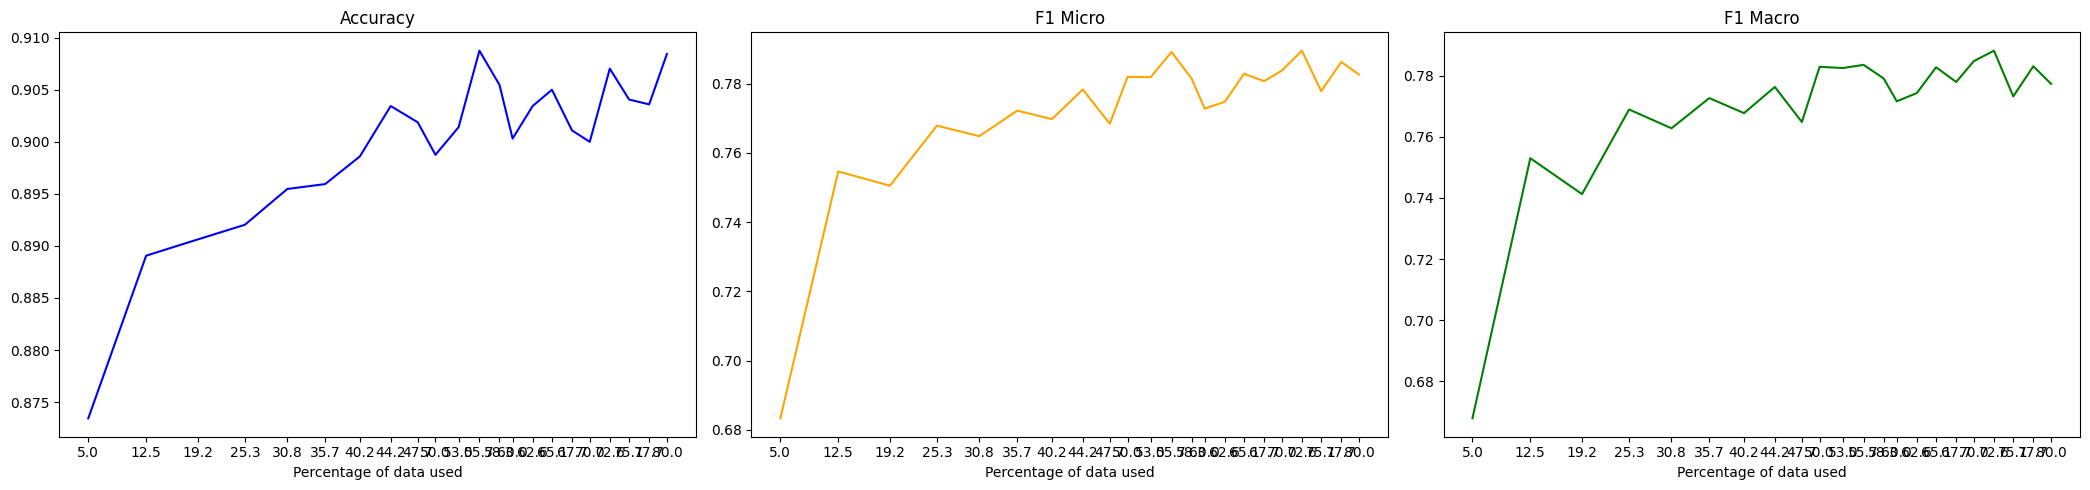

In [22]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5896, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4953, Accuracy: 0.79, F1 Micro: 0.0303, F1 Macro: 0.0269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4288, Accuracy: 0.8306, F1 Micro: 0.3593, F1 Macro: 0.2395
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3915, Accuracy: 0.835, F1 Micro: 0.4413, F1 Macro: 0.3366
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3345, Accuracy: 0.8445, F1 Micro: 0.4826, F1 Macro: 0.381
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2887, Accuracy: 0.8612, F1 Micro: 0.6162, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2536, Accuracy: 0.8698, F1 Micro: 0.6548, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2078, Accuracy: 0.8711, F1 Micro: 0.6642, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1918, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.545, Accuracy: 0.788, F1 Micro: 0.0117, F1 Macro: 0.0106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4192, Accuracy: 0.8423, F1 Micro: 0.478, F1 Macro: 0.3982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.323, Accuracy: 0.8772, F1 Micro: 0.692, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2632, Accuracy: 0.8797, F1 Micro: 0.7041, F1 Macro: 0.6926
Epoch 5/10, Train Loss: 0.209, Accuracy: 0.8822, F1 Micro: 0.6962, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1736, Accuracy: 0.8859, F1 Micro: 0.7239, F1 Macro: 0.7176
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1328, Accuracy: 0.8866, F1 Micro: 0.7438, F1 Macro: 0.7404
Epoch 8/10, Train Loss: 0.1146, Accuracy: 0.8886, F1 Micro: 0.7257, F1 Macro: 0.6998
Epoch 9/10, Train Loss: 0.0901, Accuracy: 0.8922, F1 Micro: 0.7384, F1 Macro: 0.7288
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5111, Accuracy: 0.8217, F1 Micro: 0.2864, F1 Macro: 0.1961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3691, Accuracy: 0.8659, F1 Micro: 0.6159, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.283, Accuracy: 0.8784, F1 Micro: 0.6742, F1 Macro: 0.6655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2316, Accuracy: 0.8873, F1 Micro: 0.7329, F1 Macro: 0.7294
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1898, Accuracy: 0.8892, F1 Micro: 0.7573, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1513, Accuracy: 0.8883, F1 Micro: 0.759, F1 Macro: 0.7604
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1262, Accuracy: 0.8908, F1 Micro: 0.7604, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.8952, F1 Micro: 0.7616, F1 Macro: 0.7608
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.895, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4847, Accuracy: 0.837, F1 Micro: 0.4322, F1 Macro: 0.357
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3271, Accuracy: 0.8781, F1 Micro: 0.6847, F1 Macro: 0.6723
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2594, Accuracy: 0.8881, F1 Micro: 0.7259, F1 Macro: 0.7059
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2076, Accuracy: 0.8891, F1 Micro: 0.759, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1707, Accuracy: 0.8936, F1 Micro: 0.7673, F1 Macro: 0.7674
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.8958, F1 Micro: 0.7531, F1 Macro: 0.7459
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.8955, F1 Micro: 0.7532, F1 Macro: 0.7461
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.8928, F1 Micro: 0.7291, F1 Macro: 0.7132
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.8958, F1 Micro: 0.7525, F1 Macro: 0.7458
Epoch 10/10, Train Loss: 0.0471, Accuracy: 0.8948, F1 Micro: 0.7497, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4594, Accuracy: 0.8536, F1 Micro: 0.5672, F1 Macro: 0.4789
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3107, Accuracy: 0.883, F1 Micro: 0.7287, F1 Macro: 0.7287
Epoch 3/10, Train Loss: 0.2477, Accuracy: 0.8903, F1 Micro: 0.7241, F1 Macro: 0.7089
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2095, Accuracy: 0.8916, F1 Micro: 0.7367, F1 Macro: 0.7298
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.8956, F1 Micro: 0.7535, F1 Macro: 0.7481
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1179, Accuracy: 0.8939, F1 Micro: 0.755, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0864, Accuracy: 0.8963, F1 Micro: 0.7632, F1 Macro: 0.7611
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.8959, F1 Micro: 0.7694, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.8959, F1 Micro: 0.762, F1 Macro: 0.7603
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4538, Accuracy: 0.8567, F1 Micro: 0.5525, F1 Macro: 0.5081
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3078, Accuracy: 0.8798, F1 Micro: 0.681, F1 Macro: 0.6589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2517, Accuracy: 0.8942, F1 Micro: 0.7544, F1 Macro: 0.747
Epoch 4/10, Train Loss: 0.2009, Accuracy: 0.8923, F1 Micro: 0.7299, F1 Macro: 0.7112
Epoch 5/10, Train Loss: 0.1536, Accuracy: 0.8928, F1 Micro: 0.7088, F1 Macro: 0.6869
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9002, F1 Micro: 0.7676, F1 Macro: 0.7611
Epoch 7/10, Train Loss: 0.0867, Accuracy: 0.8928, F1 Micro: 0.7553, F1 Macro: 0.7559
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.8991, F1 Micro: 0.7635, F1 Macro: 0.7605
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.8986, F1 Micro: 0.7686, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.8978, F1 Micro: 0.7618, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4464, Accuracy: 0.8767, F1 Micro: 0.6943, F1 Macro: 0.6894
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2982, Accuracy: 0.8914, F1 Micro: 0.7495, F1 Macro: 0.747
Epoch 3/10, Train Loss: 0.2539, Accuracy: 0.8936, F1 Micro: 0.7437, F1 Macro: 0.738
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.204, Accuracy: 0.9, F1 Micro: 0.7652, F1 Macro: 0.7648
Epoch 5/10, Train Loss: 0.1539, Accuracy: 0.8978, F1 Micro: 0.7415, F1 Macro: 0.7338
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.8988, F1 Micro: 0.7479, F1 Macro: 0.742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9005, F1 Micro: 0.7711, F1 Macro: 0.7716
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.898, F1 Micro: 0.7611, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.8991, F1 Micro: 0.7762, F1 Macro: 0.7773
Epoch 10/10, Train Loss: 0.0416, Accuracy: 0.8997, F1 Micro: 0.7735, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4378, Accuracy: 0.8694, F1 Micro: 0.6327, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2922, Accuracy: 0.8909, F1 Micro: 0.7199, F1 Macro: 0.7117
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2425, Accuracy: 0.8977, F1 Micro: 0.7394, F1 Macro: 0.7229
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1984, Accuracy: 0.9006, F1 Micro: 0.7701, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1602, Accuracy: 0.9025, F1 Micro: 0.7778, F1 Macro: 0.7772
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.902, F1 Micro: 0.7654, F1 Macro: 0.7583
Epoch 7/10, Train Loss: 0.0895, Accuracy: 0.9003, F1 Micro: 0.7692, F1 Macro: 0.7665
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9023, F1 Micro: 0.7815, F1 Macro: 0.7822
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9052, F1 Micro: 0.7851, F1 Macro: 0.7869
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4284, Accuracy: 0.8772, F1 Micro: 0.6878, F1 Macro: 0.6903
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2942, Accuracy: 0.893, F1 Micro: 0.7535, F1 Macro: 0.7504
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2396, Accuracy: 0.9008, F1 Micro: 0.7677, F1 Macro: 0.7627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2066, Accuracy: 0.9023, F1 Micro: 0.7688, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.9039, F1 Micro: 0.7741, F1 Macro: 0.7654
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.8997, F1 Micro: 0.7738, F1 Macro: 0.768
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9006, F1 Micro: 0.7719, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.8992, F1 Micro: 0.7786, F1 Macro: 0.7771
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9045, F1 Micro: 0.7792, F1 Macro: 0.7779
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4295, Accuracy: 0.8792, F1 Micro: 0.7073, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.292, Accuracy: 0.8942, F1 Micro: 0.7539, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2304, Accuracy: 0.9014, F1 Micro: 0.7733, F1 Macro: 0.7685
Epoch 4/10, Train Loss: 0.1851, Accuracy: 0.9038, F1 Micro: 0.7623, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1482, Accuracy: 0.9031, F1 Micro: 0.7859, F1 Macro: 0.7841
Epoch 6/10, Train Loss: 0.1099, Accuracy: 0.9008, F1 Micro: 0.7592, F1 Macro: 0.7464
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9036, F1 Micro: 0.7721, F1 Macro: 0.7677
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.902, F1 Micro: 0.7831, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9047, F1 Micro: 0.782, F1 Macro: 0.7799
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.9033, F1 Micro: 0.7773, F1 Macro: 0.7774

 Iteration 3886: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.421, Accuracy: 0.8775, F1 Micro: 0.6906, F1 Macro: 0.6819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2729, Accuracy: 0.8973, F1 Micro: 0.7551, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2313, Accuracy: 0.9033, F1 Micro: 0.7642, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.8994, F1 Micro: 0.7739, F1 Macro: 0.7694
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9031, F1 Micro: 0.7727, F1 Macro: 0.769
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.8997, F1 Micro: 0.7576, F1 Macro: 0.749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9053, F1 Micro: 0.7762, F1 Macro: 0.7668
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9027, F1 Micro: 0.776, F1 Macro: 0.7723
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0405, Accuracy: 0.9031, F1 Micro: 0.7849, F1 Macro: 0.7828
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4086, Accuracy: 0.8817, F1 Micro: 0.7204, F1 Macro: 0.7125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2695, Accuracy: 0.8936, F1 Micro: 0.767, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2276, Accuracy: 0.9033, F1 Micro: 0.7693, F1 Macro: 0.7627
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9008, F1 Micro: 0.7677, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1393, Accuracy: 0.9047, F1 Micro: 0.7766, F1 Macro: 0.7724
Epoch 6/10, Train Loss: 0.1065, Accuracy: 0.902, F1 Micro: 0.7687, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9052, F1 Micro: 0.7884, F1 Macro: 0.7871
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9078, F1 Micro: 0.7823, F1 Macro: 0.7785
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.9045, F1 Micro: 0.7777, F1 Macro: 0.7735
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9061, F1 Micro: 0.7758, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4106, Accuracy: 0.8805, F1 Micro: 0.7123, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2742, Accuracy: 0.8972, F1 Micro: 0.7618, F1 Macro: 0.7574
Epoch 3/10, Train Loss: 0.2242, Accuracy: 0.9022, F1 Micro: 0.7547, F1 Macro: 0.7392
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1799, Accuracy: 0.9039, F1 Micro: 0.7687, F1 Macro: 0.7603
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9017, F1 Micro: 0.7678, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.9056, F1 Micro: 0.7712, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0791, Accuracy: 0.9055, F1 Micro: 0.7775, F1 Macro: 0.7728
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9045, F1 Micro: 0.7679, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0443, Accuracy: 0.9038, F1 Micro: 0.7843, F1 Macro: 0.786
Epoch 10/10, Train Loss: 0.0376, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3928, Accuracy: 0.883, F1 Micro: 0.7179, F1 Macro: 0.707
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2665, Accuracy: 0.8958, F1 Micro: 0.7389, F1 Macro: 0.731
Epoch 3/10, Train Loss: 0.2225, Accuracy: 0.8938, F1 Micro: 0.7157, F1 Macro: 0.7031
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9045, F1 Micro: 0.7797, F1 Macro: 0.7774
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9045, F1 Micro: 0.7781, F1 Macro: 0.775
Epoch 6/10, Train Loss: 0.1087, Accuracy: 0.9047, F1 Micro: 0.7722, F1 Macro: 0.7642
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.8998, F1 Micro: 0.7786, F1 Macro: 0.7774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0546, Accuracy: 0.9025, F1 Micro: 0.7809, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0445, Accuracy: 0.9064, F1 Micro: 0.7789, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9033, F1 Micro: 0.7817, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3917, Accuracy: 0.8838, F1 Micro: 0.7098, F1 Macro: 0.708
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.8964, F1 Micro: 0.7592, F1 Macro: 0.7484
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2194, Accuracy: 0.9052, F1 Micro: 0.7831, F1 Macro: 0.7806
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.9023, F1 Micro: 0.7642, F1 Macro: 0.7494
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.9044, F1 Micro: 0.7696, F1 Macro: 0.7569
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9017, F1 Micro: 0.7745, F1 Macro: 0.7726
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9022, F1 Micro: 0.771, F1 Macro: 0.7641
Epoch 8/10, Train Loss: 0.0529, Accuracy: 0.902, F1 Micro: 0.7679, F1 Macro: 0.7602
Epoch 9/10, Train Loss: 0.0395, Accuracy: 0.9031, F1 Micro: 0.7747, F1 Macro: 0.7704
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9044, F1 Micro: 0.7735, F1 Macro: 0.7685

 Iteration 4863: Accuracy: 0.9052, F1 Micro: 0.7831,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8808, F1 Micro: 0.7067, F1 Macro: 0.6939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.259, Accuracy: 0.8956, F1 Micro: 0.7328, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2173, Accuracy: 0.9036, F1 Micro: 0.7681, F1 Macro: 0.7573
Epoch 4/10, Train Loss: 0.1738, Accuracy: 0.9039, F1 Micro: 0.7654, F1 Macro: 0.752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9045, F1 Micro: 0.7774, F1 Macro: 0.7713
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9017, F1 Micro: 0.76, F1 Macro: 0.746
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9027, F1 Micro: 0.7727, F1 Macro: 0.7698
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.9036, F1 Micro: 0.7637, F1 Macro: 0.7572
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9038, F1 Micro: 0.7783, F1 Macro: 0.7758
Epoch 10/10, Train Loss: 0.0305, Accuracy: 0.9036, F1 Micro: 0.7742, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3921, Accuracy: 0.8881, F1 Micro: 0.745, F1 Macro: 0.7377
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.8995, F1 Micro: 0.7543, F1 Macro: 0.7507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2149, Accuracy: 0.9006, F1 Micro: 0.7585, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9011, F1 Micro: 0.7846, F1 Macro: 0.7828
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9061, F1 Micro: 0.7772, F1 Macro: 0.7675
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9047, F1 Micro: 0.7829, F1 Macro: 0.7797
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9027, F1 Micro: 0.7683, F1 Macro: 0.7617
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9036, F1 Micro: 0.7729, F1 Macro: 0.7679
Epoch 9/10, Train Loss: 0.043, Accuracy: 0.9023, F1 Micro: 0.7814, F1 Macro: 0.7807
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9022, F1 Micro: 0.7724, F1 Macro: 0.7664

 Iteration 5263: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3835, Accuracy: 0.8866, F1 Micro: 0.7212, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2666, Accuracy: 0.8989, F1 Micro: 0.7634, F1 Macro: 0.7551
Epoch 3/10, Train Loss: 0.2162, Accuracy: 0.9025, F1 Micro: 0.7626, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9052, F1 Micro: 0.7749, F1 Macro: 0.7672
Epoch 5/10, Train Loss: 0.1327, Accuracy: 0.9016, F1 Micro: 0.7663, F1 Macro: 0.7587
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9013, F1 Micro: 0.7723, F1 Macro: 0.7689
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.8989, F1 Micro: 0.77, F1 Macro: 0.7687
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9016, F1 Micro: 0.7722, F1 Macro: 0.766
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.9064, F1 Micro: 0.78, F1 Macro: 0.7774
Epoch 10/10, Train Loss: 0.0355, Accuracy: 0.9027, F1 Micro: 0.772, F1 Macro: 0.7666

 Iteration 5441: Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3783, Accuracy: 0.8756, F1 Micro: 0.6672, F1 Macro: 0.667
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2561, Accuracy: 0.8995, F1 Micro: 0.7649, F1 Macro: 0.7655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9048, F1 Micro: 0.7849, F1 Macro: 0.7786
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9083, F1 Micro: 0.7819, F1 Macro: 0.7714
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.9005, F1 Micro: 0.7778, F1 Macro: 0.775
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9042, F1 Micro: 0.7799, F1 Macro: 0.7778
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.8948, F1 Micro: 0.7738, F1 Macro: 0.772
Epoch 8/10, Train Loss: 0.0564, Accuracy: 0.9008, F1 Micro: 0.7642, F1 Macro: 0.7582
Epoch 9/10, Train Loss: 0.0387, Accuracy: 0.9011, F1 Micro: 0.7806, F1 Macro: 0.7792
Epoch 10/10, Train Loss: 0.0327, Accuracy: 0.8994, F1 Micro: 0.7807, F1 Macro: 0.7801

 Iteration 5641: Accuracy: 0.9048, F1 Micro: 0.7849,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.367, Accuracy: 0.8894, F1 Micro: 0.7204, F1 Macro: 0.7089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.8998, F1 Micro: 0.7716, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9031, F1 Micro: 0.7776, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1687, Accuracy: 0.9023, F1 Micro: 0.7831, F1 Macro: 0.7818
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9002, F1 Micro: 0.7788, F1 Macro: 0.7764
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9019, F1 Micro: 0.7798, F1 Macro: 0.7769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9066, F1 Micro: 0.784, F1 Macro: 0.7789
Epoch 8/10, Train Loss: 0.0523, Accuracy: 0.9016, F1 Micro: 0.7766, F1 Macro: 0.7723
Epoch 9/10, Train Loss: 0.04, Accuracy: 0.9038, F1 Micro: 0.7798, F1 Macro: 0.7775
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9, F1 Micro: 0.7779, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3623, Accuracy: 0.8884, F1 Micro: 0.7312, F1 Macro: 0.7298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.9025, F1 Micro: 0.7747, F1 Macro: 0.7721
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9014, F1 Micro: 0.7477, F1 Macro: 0.7402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9041, F1 Micro: 0.7844, F1 Macro: 0.7831
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.8944, F1 Micro: 0.7179, F1 Macro: 0.7008
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9011, F1 Micro: 0.7762, F1 Macro: 0.7722
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0669, Accuracy: 0.9047, F1 Micro: 0.7885, F1 Macro: 0.7856
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9038, F1 Micro: 0.7873, F1 Macro: 0.7821
Epoch 9/10, Train Loss: 0.0352, Accuracy: 0.9048, F1 Micro: 0.7791, F1 Macro: 0.7733
Epoch 10/10, Train Loss: 0.0299, Accuracy: 0.9044, F1 Micro: 0.7837, F1 Macro: 0.7812

 Iteration 6041: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3541, Accuracy: 0.89, F1 Micro: 0.7385, F1 Macro: 0.733
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2386, Accuracy: 0.8984, F1 Micro: 0.7455, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1962, Accuracy: 0.9073, F1 Micro: 0.7766, F1 Macro: 0.77
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9045, F1 Micro: 0.774, F1 Macro: 0.7621
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9061, F1 Micro: 0.7819, F1 Macro: 0.777
Epoch 6/10, Train Loss: 0.0836, Accuracy: 0.9039, F1 Micro: 0.7761, F1 Macro: 0.7688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0672, Accuracy: 0.9081, F1 Micro: 0.7886, F1 Macro: 0.7861
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9067, F1 Micro: 0.7827, F1 Macro: 0.7771
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9042, F1 Micro: 0.7802, F1 Macro: 0.7776
Epoch 10/10, Train Loss: 0.0271, Accuracy: 0.9028, F1 Micro: 0.7786, F1 Macro

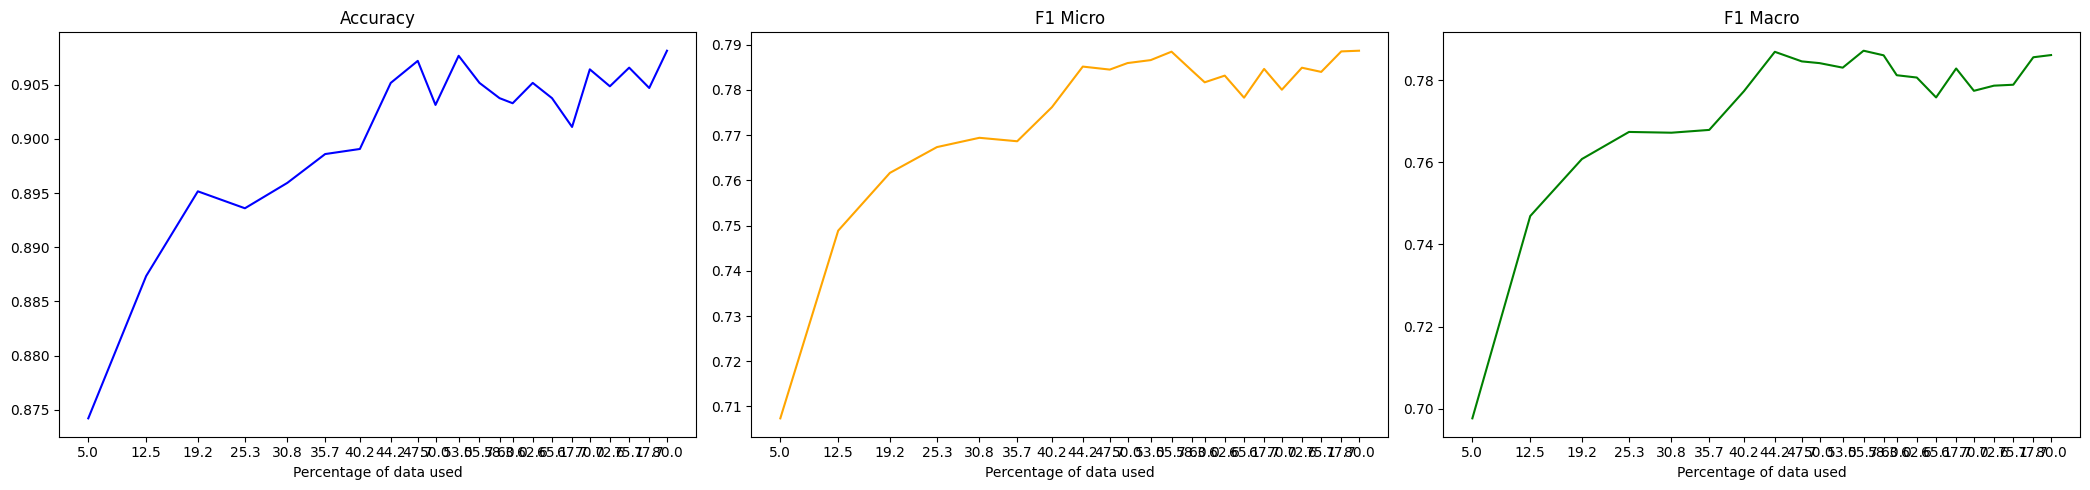

In [23]:
active_learning(seeds[4], 4)